# Lending Club Analysis

## Introduction
In this analysis, we aim to predict the likelihood of defaulting on a loan using data from Lending Club. We will start by using a logistic regression model for this purpose. The performance of the model will be evaluated using various metrics, including the confusion matrix, Area Under the Curve (AUC), Kolmogorov-Smirnov (KS) statistic, and SHapley Additive exPlanations (SHAP) values.

Jack Cook
6/28/2024

## Data Loading and Preprocessing
In this section, we will load the Lending Club dataset and perform necessary preprocessing steps.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 5000)
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
# Sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay,
    RocCurveDisplay
)
from scipy.stats import ks_2samp
from sklearn import metrics
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV
)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Other necessary libraries
import shap
import scikitplot as skplt
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb


plt.rcParams['figure.figsize'] = (15,12)

#Load the dataset
loans = pd.read_csv('Documents/LendingClub/filtered_loans.csv')
loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,10.65,162.87,10,24000.0,1,860,27.65,0.0,739.0,1.0,3.0,0.0,13648.0,83.7,9.0,744.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2500.0,15.27,59.83,0,30000.0,0,309,1.00,0.0,744.0,5.0,3.0,0.0,1687.0,9.4,4.0,499.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2400.0,15.96,84.33,10,12252.0,1,606,8.72,0.0,739.0,2.0,2.0,0.0,2956.0,98.5,10.0,719.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,10000.0,13.49,339.31,10,49200.0,1,917,20.00,0.0,694.0,1.0,10.0,0.0,5598.0,21.0,37.0,604.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5000.0,7.90,156.46,3,36000.0,1,852,11.20,0.0,734.0,3.0,9.0,0.0,7963.0,28.3,12.0,679.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Create Target Variable - Default

To facilitate predictive modeling, we create a binary target variable 'default' based on the loan status. This variable is defined as follows:

- **1**: Indicates that the loan has defaulted, encompassing statuses such as 'Charged Off' and 'Default'.
- **0**: Indicates that the loan is fully paid off, including statuses such as 'Fully Paid' and others.


In [2]:
loans['default'] = loans['loan_status'].apply(lambda x:0 if x ==1 else 1)

## Data Cleaning and Feature Selection

In this section, we perform data cleaning and feature selection on the 'loans' dataset to prepare it for predictive modeling of loan defaults.

### Steps:

1. **Drop Irrelevant Columns:**
   - We remove columns that are not essential for predicting loan defaults. This includes:
     - **'loan_status'**: Since we have already derived the 'default' variable from it.
     - **'zip_code'**: Typically not predictive of loan default behavior.
     - **'verification_status_Not Verified'** and **'verification_status_Source Verified'**: Variants of verification status that do not significantly impact default predictions and create noise in evaluation.
     - **'term_ 36 months'** and **'term_ 60 months'**: Loan term information are deemed less relevant in predicting default as it is assigned after the loan is created.
   

In [3]:
loans = loans.drop(columns = ['loan_status', 'zip_code', 'verification_status_Not Verified', 'verification_status_Source Verified', 'term_ 36 months', 'term_ 60 months'])
#Used later in XGBoost section
loans_copy = loans
loans = loans.dropna()
loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,default
0,5000.0,10.65,162.87,10,24000.0,27.65,0.0,739.0,1.0,3.0,0.0,13648.0,83.7,9.0,744.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2500.0,15.27,59.83,0,30000.0,1.00,0.0,744.0,5.0,3.0,0.0,1687.0,9.4,4.0,499.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2400.0,15.96,84.33,10,12252.0,8.72,0.0,739.0,2.0,2.0,0.0,2956.0,98.5,10.0,719.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,10000.0,13.49,339.31,10,49200.0,20.00,0.0,694.0,1.0,10.0,0.0,5598.0,21.0,37.0,604.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,5000.0,7.90,156.46,3,36000.0,11.20,0.0,734.0,3.0,9.0,0.0,7963.0,28.3,12.0,679.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


## Distribution Analysis of Key Numerical Features

To understand the distribution of key numerical variables in the dataset and identify any skewness that may require normalization, we visualize their distributions using histograms. This analysis helps in assessing whether log transformation is necessary to achieve a more normalized distribution.


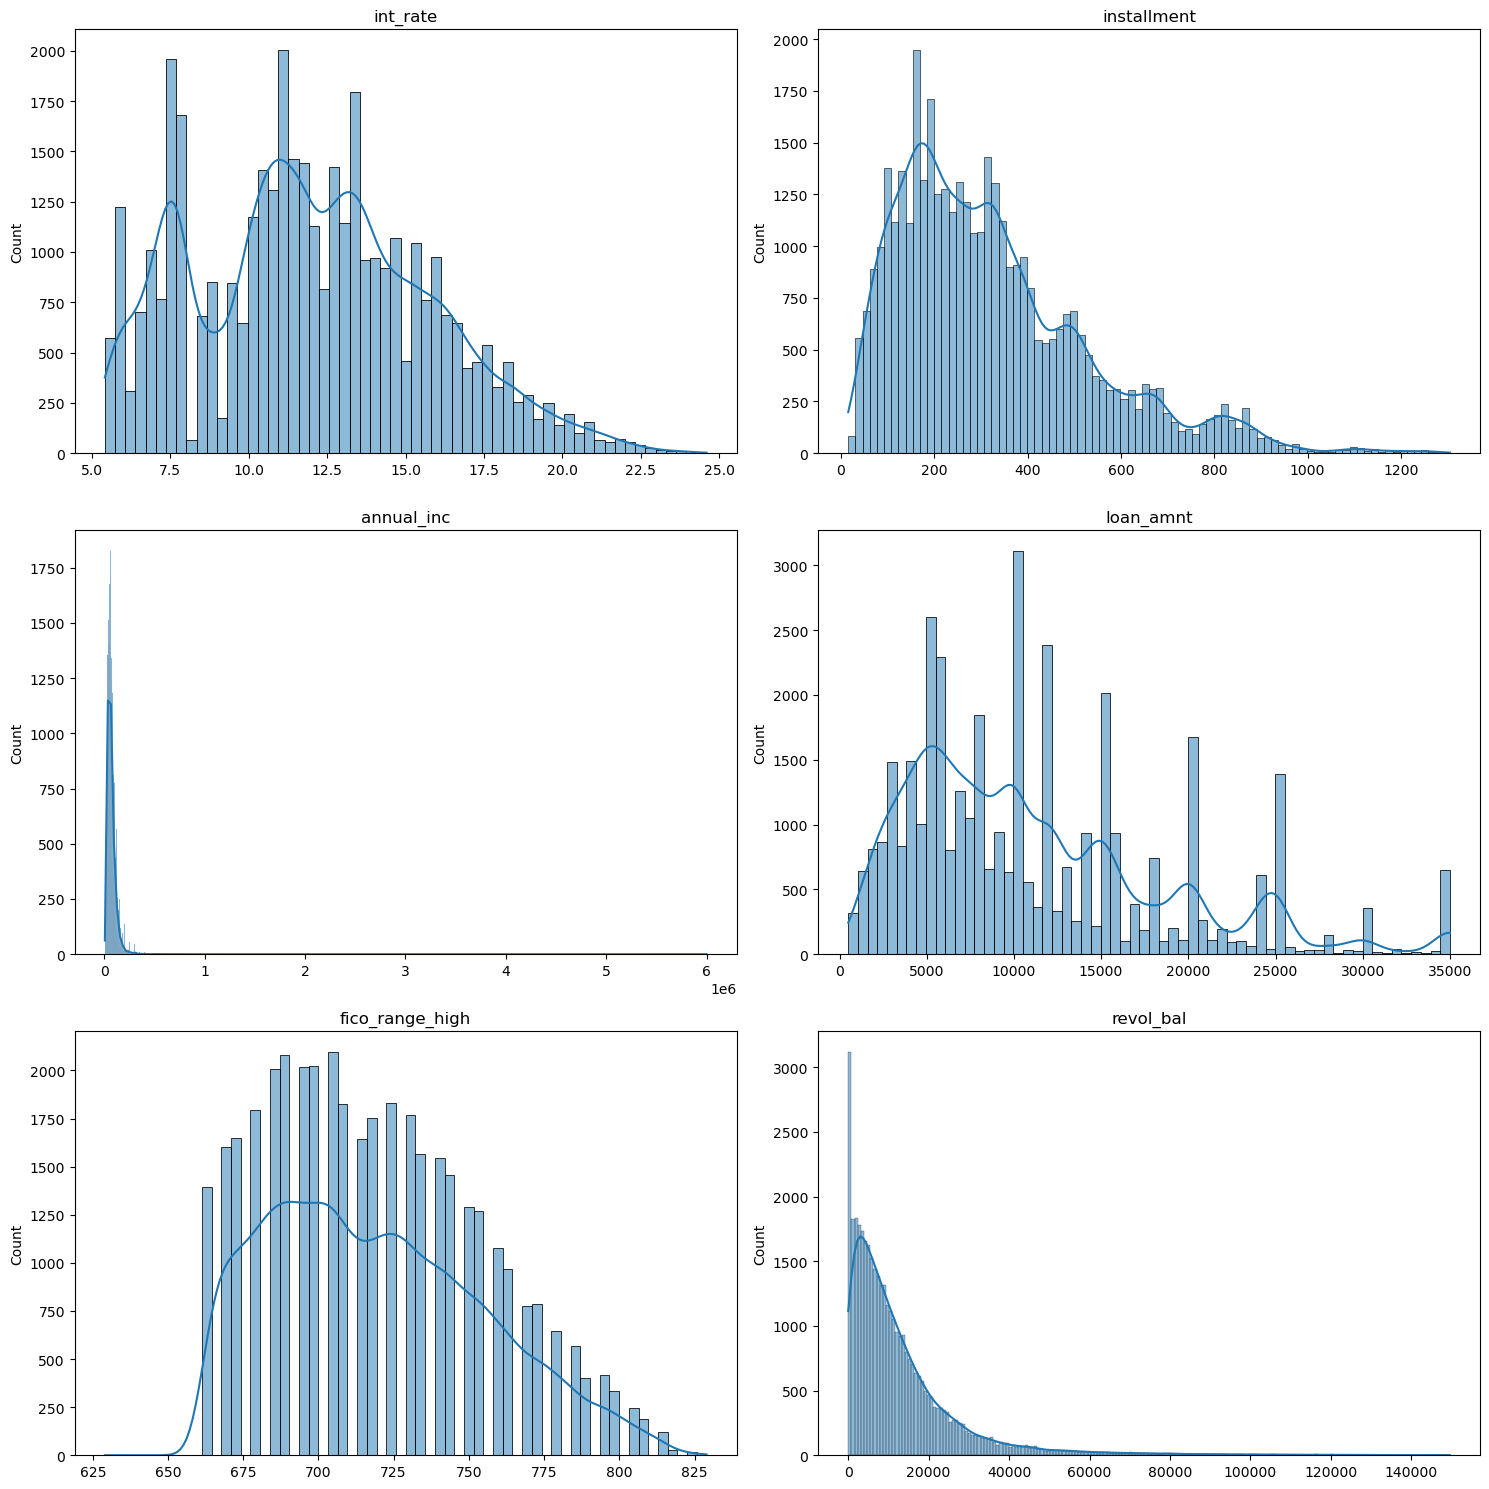

In [4]:
# Distribution of Key Numerical Features
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
numerical_features = ['int_rate', 'installment', 'annual_inc', 'loan_amnt', 'fico_range_high', 'revol_bal']
for i, ax in enumerate(axes.flatten()):
    sns.histplot(loans[numerical_features[i]], kde=True, ax=ax)
    ax.set_title(numerical_features[i])
    ax.set_xlabel('')
plt.tight_layout()

## Log Transformation of Numerical Features

To address skewness and improve the distribution of key numerical variables, we perform a log transformation on 'annual_inc', 'installment', 'revol_bal', and 'loan_amnt'. This transformation helps normalize these variables, which can enhance model performance and interpretability.


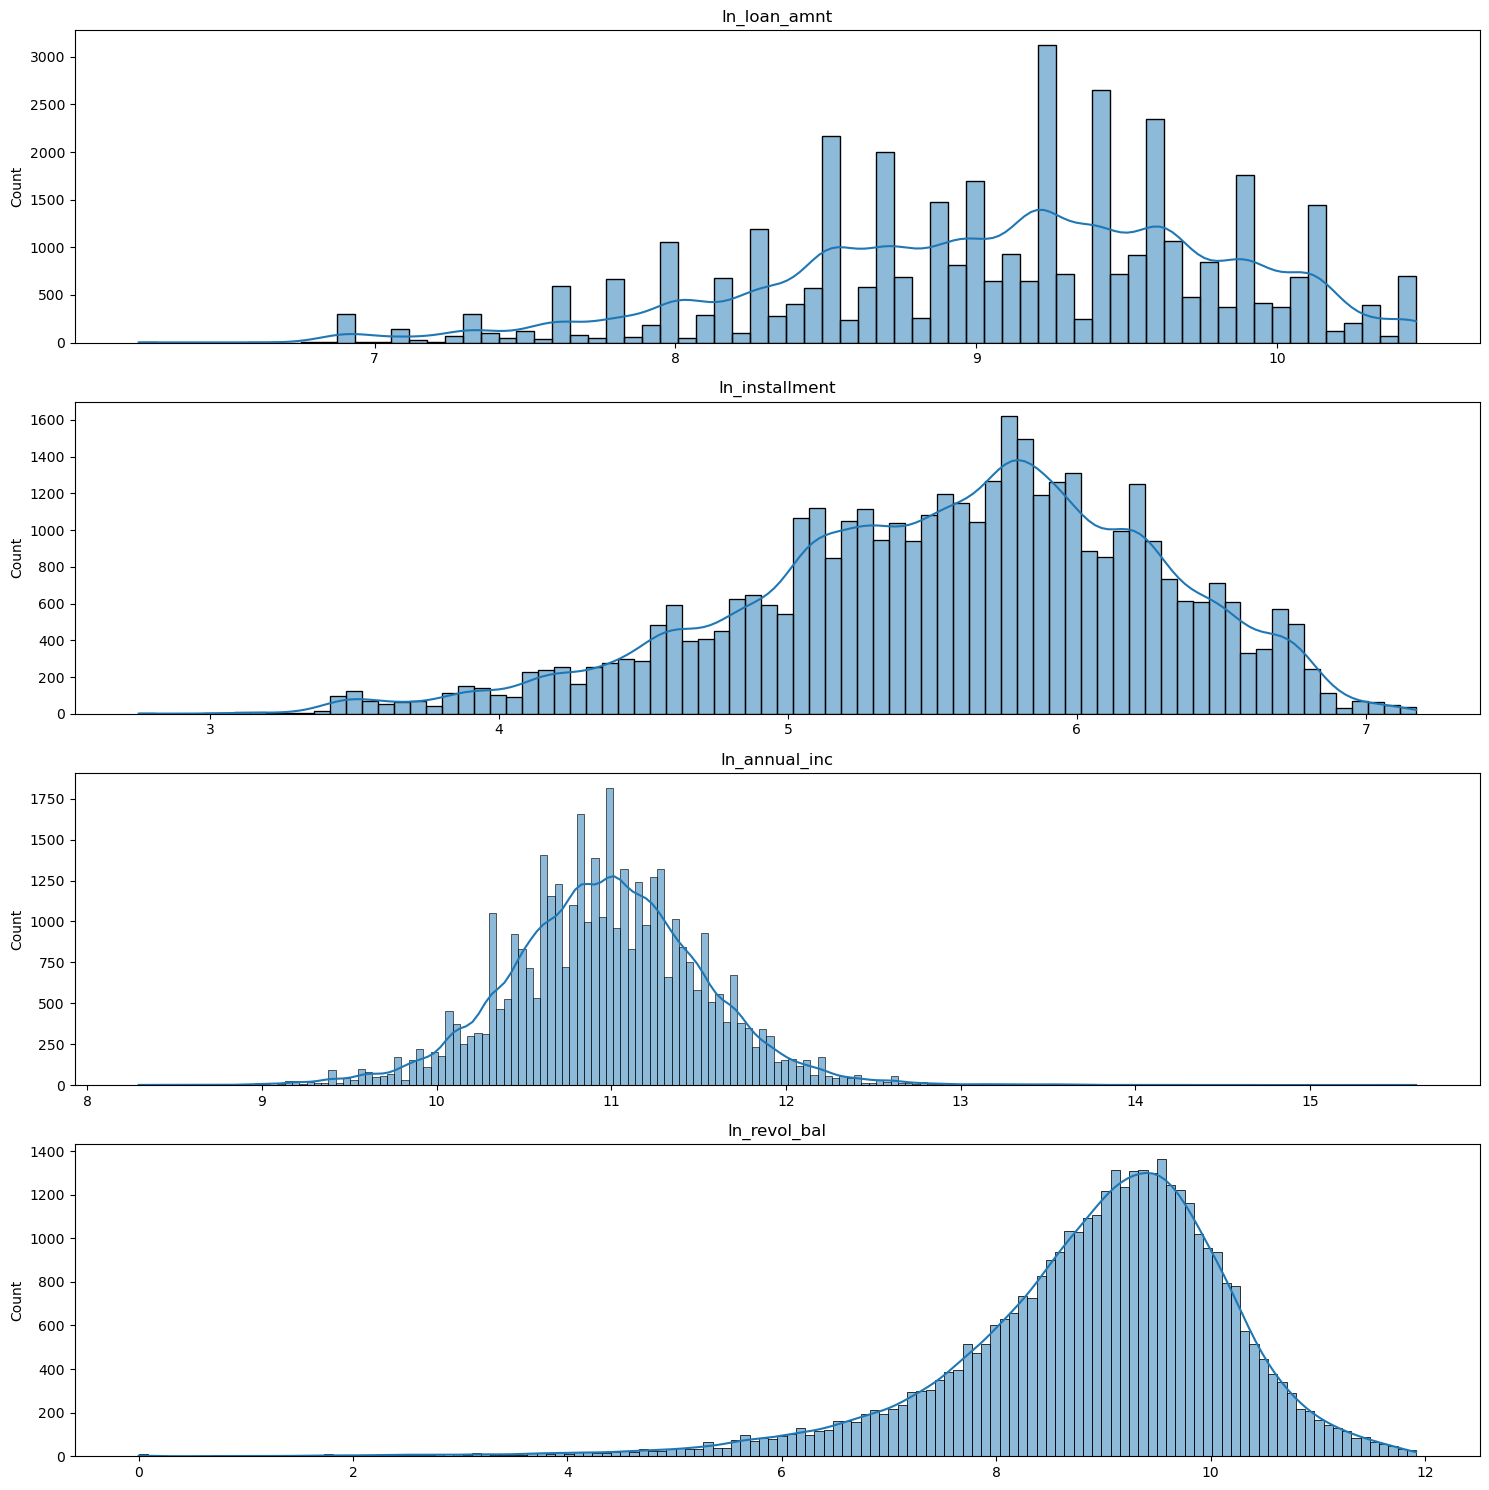

In [5]:
# Perform Log Transformation
loans['ln_annual_inc'] = np.log(loans['annual_inc'])
loans['ln_installment'] = np.log(loans['installment'])
loans['ln_revol_bal'] = np.log(loans['revol_bal'])
loans['ln_loan_amnt'] = np.log(loans['loan_amnt'])
loans = loans.drop(columns=['annual_inc', 'installment', 'revol_bal', 'loan_amnt'])

# Distribution of Key Numerical Features
fig, axes = plt.subplots(4, 1, figsize=(15, 15))
numerical_features = ['ln_loan_amnt','ln_installment', 'ln_annual_inc','ln_revol_bal']

for i, ax in enumerate(axes.flatten()):
    sns.histplot(loans[numerical_features[i]], kde=True, ax=ax)
    ax.set_title(numerical_features[i])
    ax.set_xlabel('')
    
plt.tight_layout()

## Distribution of Defaulted Loans

To understand the distribution of defaulted loans in our dataset, we analyze the distribution of the target variable 'default', where:
- **1** represents loans that have defaulted.
- **0** represents loans that have been fully paid off or are current.

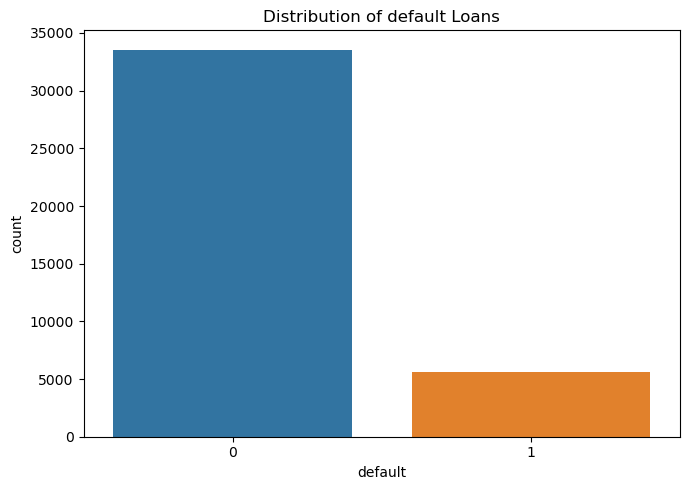

In [6]:
# Distribution of Defaulted Loans
fig, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x=loans['default'])
ax.set_title('Distribution of default Loans')
plt.tight_layout()

plt.show()

#### Replace Negative Infinity Values and Drop NaNs

In [7]:
# Replace negative infinity values with NaN to facilitate data cleaning and handling missing values
loans.replace(-np.inf, np.nan, inplace=True)

# Drop rows with NaN values to ensure dataset integrity and maintain data quality for analysis
loans = loans.dropna()

# Display summary statistics of the cleaned dataset to understand central tendency and dispersion of numerical variables
loans.describe()


,int_rate,emp_length,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,last_fico_range_high,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,default,ln_annual_inc,ln_installment,ln_revol_bal,ln_loan_amnt
count,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000,38263.000000
mean,11.988736,4.836239,13.402558,0.143219,718.554661,0.868594,9.381726,0.055667,49.879235,22.202833,691.739984,0.443666,0.000078,0.002404,0.076758,0.477093,0.319996,0.038418,0.131772,0.474479,0.007945,0.073805,0.009199,0.054125,0.017354,0.014244,0.098346,0.002535,0.044821,0.009487,0.023469,0.143951,10.975061,5.564650,8.916036,9.086737
std,3.709657,3.604333,6.629654,0.483785,35.569918,1.066025,4.386788,0.238336,27.690746,11.428070,79.472376,0.496823,0.008854,0.048976,0.266211,0.499482,0.466481,0.192206,0.338247,0.499355,0.088781,0.261457,0.095473,0.226268,0.130587,0.118495,0.297785,0.050286,0.206914,0.096939,0.151390,0.351045,0.556232,0.700672,1.305788,0.730321
min,5.420000,0.000000,0.000000,0.000000,629.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.294050,2.777576,0.000000,6.214608
25%,9.010000,2.000000,8.300000,0.000000,689.000000,0.000000,6.000000,0.000000,27.000000,14.000000,649.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.616437,5.121222,8.295424,8.612503
50%,11.830000,4.000000,13.500000,0.000000,714.000000,1.000000,9.000000,0.000000,50.200000,21.000000,699.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.986445,5.637286,9.115040,9.210340
75%,14.460000,9.000000,18.640000,0.000000,744.000000,1.000000,12.000000,0.000000,72.900000,29.000000,749.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.319341,6.064111,9.758057,9.615805
max,24.590000,10.000000,29.990000,11.000000,829.000000,8.000000,44.000000,4.000000,99.900000,90.000000,850.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.607270,7.174104,11.915640,10.463103


## Scaling Numerical Features

Before modeling, it's essential to scale numerical features to ensure that our model treats all features equally. This step involves standardizing the range of continuous input variables so that each feature contributes proportionately to the final prediction. We employ StandardScaler for this purpose, which normalizes the features to have a mean of 0 and a standard deviation of 1.

In [8]:
loans = loans.drop(columns = ['verification_status_Verified','last_fico_range_high', 'home_ownership_OTHER', 'home_ownership_MORTGAGE', 'home_ownership_NONE',  'home_ownership_RENT', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other','purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding'])
# Initializing the StandardScaler
scaler = StandardScaler()

# List of numerical features to scale
numerical_features = ['total_acc','ln_revol_bal','ln_loan_amnt', 'emp_length', 'dti', 'fico_range_high','delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_util', 'ln_annual_inc']  

# Applying the scaler to the numerical features
loans[numerical_features] = scaler.fit_transform(loans[numerical_features])

#### Splitting the dataset into features and the target variable

In [9]:
# Define the feature columns and target variable
X = loans.drop(columns=['default'], axis = 1)  # Replace 'target_column' with the actual name of your target variable
y = loans['default']  # Replace 'target_column' with the actual name of your target variable

## Checking for Multicollinearity

Before proceeding with logistic regression modeling, it's crucial to assess multicollinearity among predictor variables. Multicollinearity occurs when independent variables in a regression model are highly correlated, which can lead to unreliable estimates of coefficients and reduced model interpretability.

### How to Check Multicollinearity:

 **Correlation Matrix:**
   - Compute the correlation matrix of predictor variables.
   - Identify pairs of variables with high correlation coefficients (typically above 0.8).
   - High correlations indicate potential multicollinearity issues.


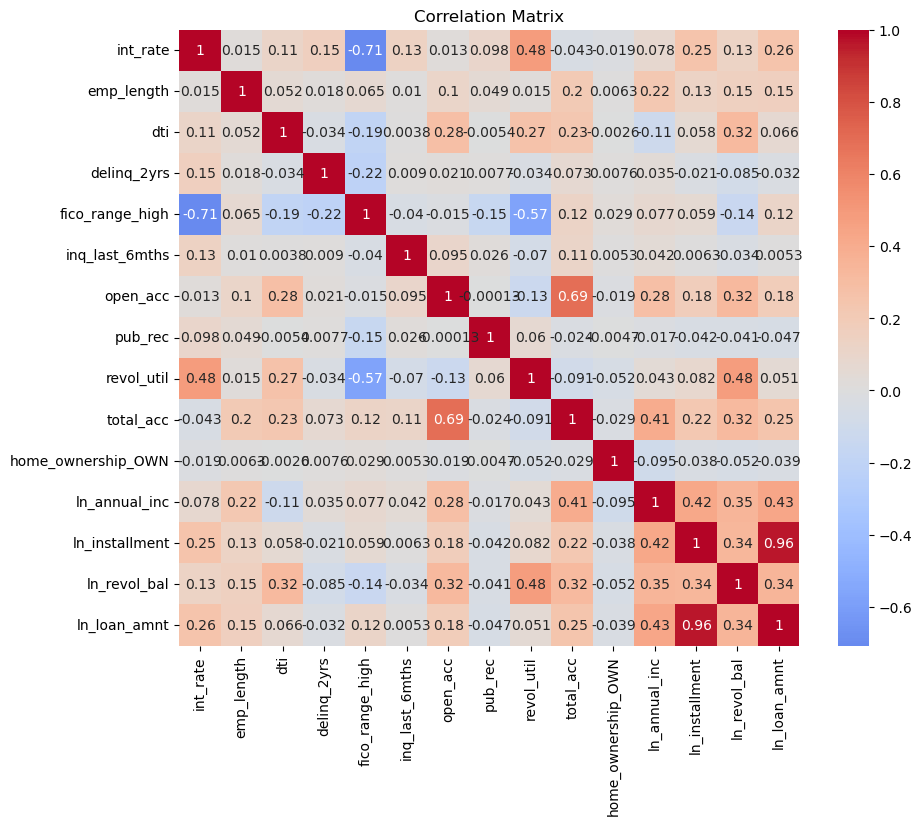

In [10]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


## Exclude Highly Correlated Variables

To mitigate multicollinearity, we will exclude variables that have a correlation coefficient of 0.75 or higher with other predictors.


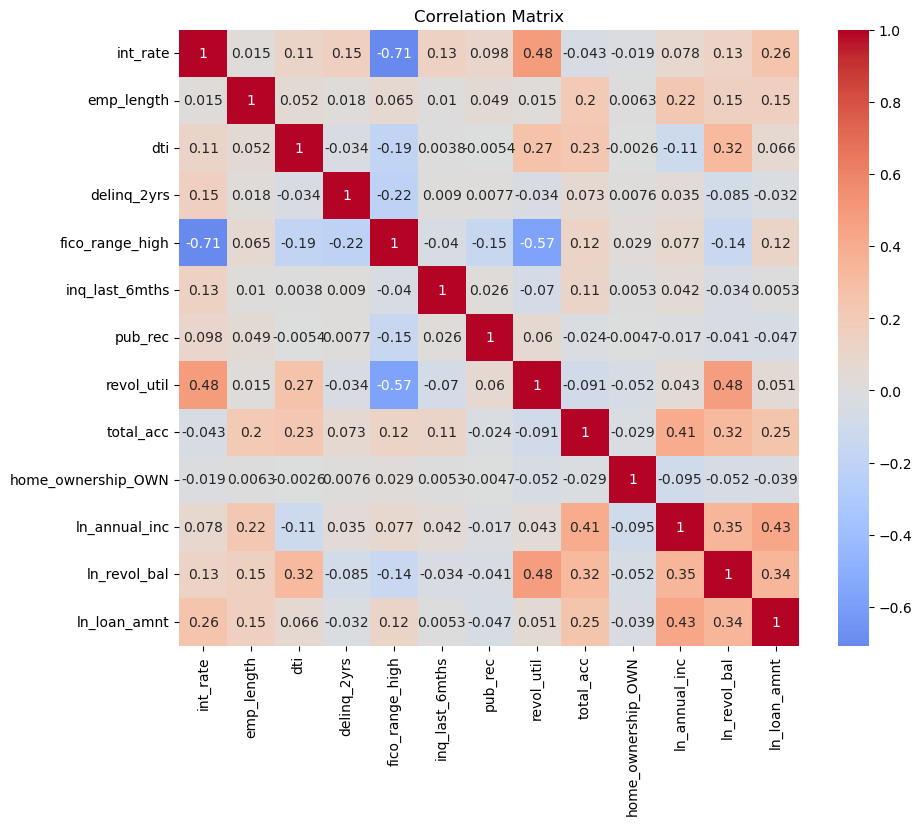

In [11]:
# Variables to be excluded due to high correlation
variables_to_drop = ['ln_installment', 'open_acc']

# Exclude highly correlated variables
X = X.drop(columns=variables_to_drop)

# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Splitting Data into Training and Test Sets

To prepare for model training and evaluation, we split the dataset into training and test sets using the `train_test_split` function from `sklearn.model_selection`.


In [12]:
# Create copies of predictors (X) and target (y) variables
X_copy = X
y_copy = y

# Split the scaled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Handling Imbalanced Data

Our dataset exhibits an imbalance in the distribution of the target variable, which can lead to biased model performance favoring the majority class. To mitigate this issue, we apply `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority class within the training set.

In [13]:
# Initializing SMOTE for oversampling
smote = SMOTE(random_state=42)

# Applying SMOTE to the training data to balance class distribution
X_train, y_train = smote.fit_resample(X_train, y_train)

## Logistic Regression Model Using Statsmodels

To build and analyze a logistic regression model, we utilize `statsmodels`, a Python library for statistical modeling. This library will output the coefficients of our model.


In [14]:
# Add a constant term to the predictors in both training and test sets
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the summary of the logistic regression model
print("\nStatsmodels Logistic Regression Model Summary:")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.634776
         Iterations 5

Statsmodels Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                52418
Model:                          Logit   Df Residuals:                    52404
Method:                           MLE   Df Model:                           13
Date:                Fri, 28 Jun 2024   Pseudo R-squ.:                 0.08421
Time:                        09:01:03   Log-Likelihood:                -33274.
converged:                       True   LL-Null:                       -36333.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.0710      0.055    

## Function: Evaluate Model Performance

This function, `evaluate_model`, is designed to evaluate the performance of a machine learning model comprehensively. It generates evaluation scores and visualizations including confusion matrices, ROC curves with AUC scores, KS statistic, and SHAP (SHapley Additive exPlanations) values for feature importance.


In [15]:
def evaluate_model(model_name, data_x, data_y, threshold):
    """
    Evaluate the performance of a machine learning model.

    Parameters:
    - model_name: Fitted machine learning model object
    - data_x: Input features for prediction
    - data_y: True labels for evaluation

    Returns:
    Prints evaluation metrics and plots
    """
    # prediction on training/test set
    y_prediction = model_name.predict(data_x)
    y_pred_prob_lgt = model_name.predict_proba(data_x)[:,1]
    

    y_pred_adjusted = (y_pred_prob_lgt >= threshold).astype(int)

    print('\n') # insert a break line
    
    # print out confusion matrix coresponding to the data set
    print('1) CONFUSION MATRIX')
    cm= confusion_matrix(data_y, y_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Default'])
    disp.plot()
    plt.show()    
    
    
    # print out auc and ks statistic
    print('\n')
    print('2) AUC and ROC Curve')
    auc =  metrics.roc_auc_score(data_y, y_pred_prob_lgt)

    print("AUC score: ", auc)
    
    RocCurveDisplay.from_estimator(model_name, data_x, data_y)
    plt.title('ROC curve', fontsize=16)
    plt.show()

    #print out ks statistic
    print('\n')
    print('3) KS Statistic')
    ks_statistic, p_value = ks_2samp(data_y, y_pred_prob_lgt)
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-Value: {p_value}")

    
    #print SHAP values
    #print out SHAP Values
    print('\n')
    print('4) SHAP')
    #  explain the model's predictions using SHAP
    explainer = shap.LinearExplainer(model_name, data_x, feature_name=data_x.columns)
    shap_values = explainer(data_x)
    # Plot the summary plot to visualize feature importance
    shap.summary_plot(shap_values, data_x)
    shap.plots.bar(shap_values)

# Example usage:
# evaluate_model(logit_model, X_test, y_test, optimal_threshold)

## Logistic Regression Model Training and Evaluation Using Scikit-Learn

In this section, we instantiate a logistic regression model using scikit-learn (`sklearn`) and evaluate its performance using the `evaluate_model` function.

In [16]:
logit_model = LogisticRegression(solver='liblinear', multi_class ='ovr', class_weight = {0:0.2, 1:0.8}, verbose = 1, random_state=42)
logit_model.fit(X_train, y_train)

[LibLinear]

LogisticRegression(class_weight={0: 0.2, 1: 0.8}, multi_class='ovr',
                   random_state=42, solver='liblinear', verbose=1)

## Find Optimal Threshold for Confustion Matrix

 Find the optimal decision threshold to balance sensitivity and specificity. This can help improve the practical performance of the model.


In [17]:

y_prob = logit_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * recall * precision / (recall + precision)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal threshold: {optimal_threshold}')
y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)

Optimal threshold: 0.8414705418197366




1) CONFUSION MATRIX


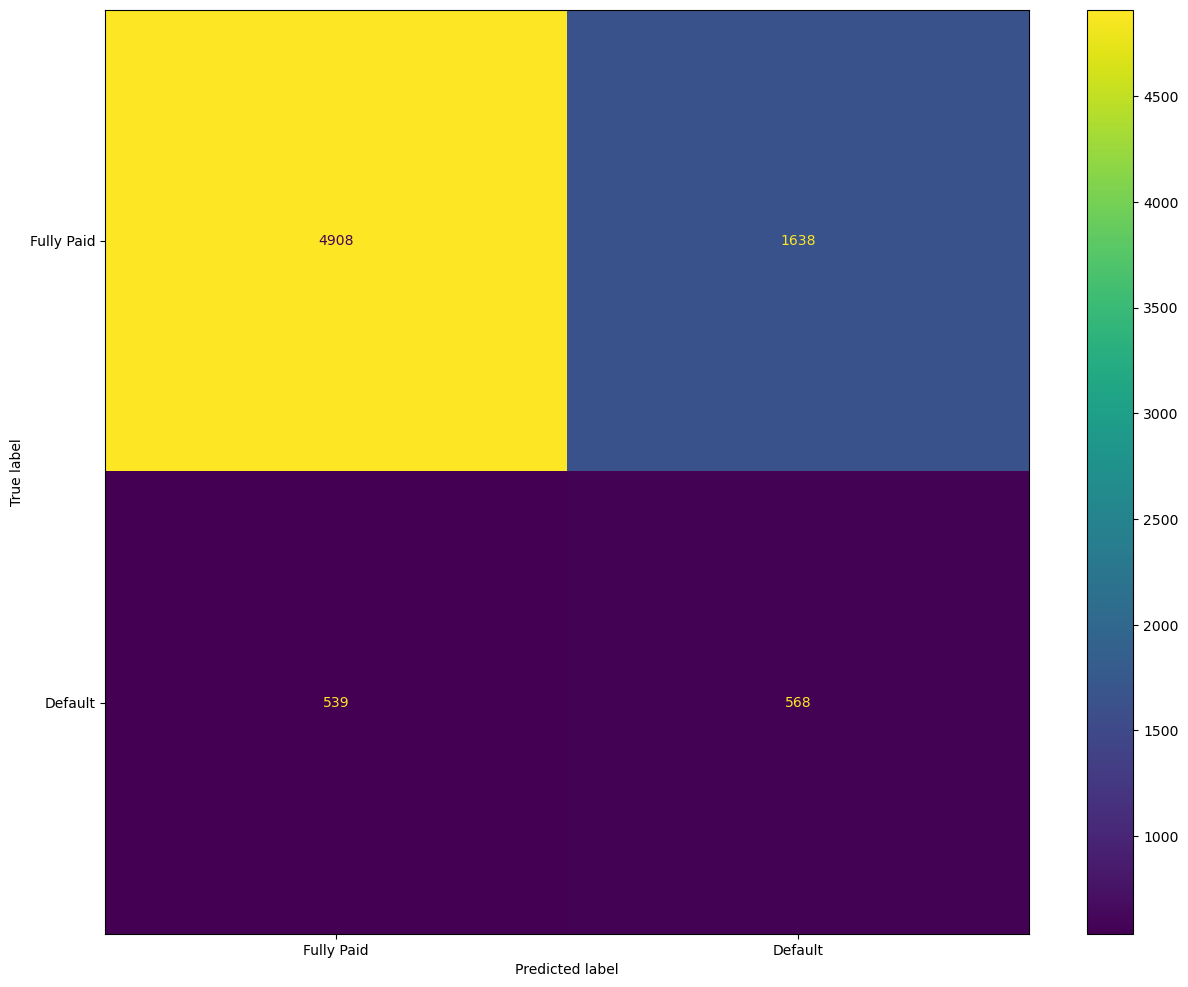



2) AUC and ROC Curve
AUC score:  0.6841630255593727


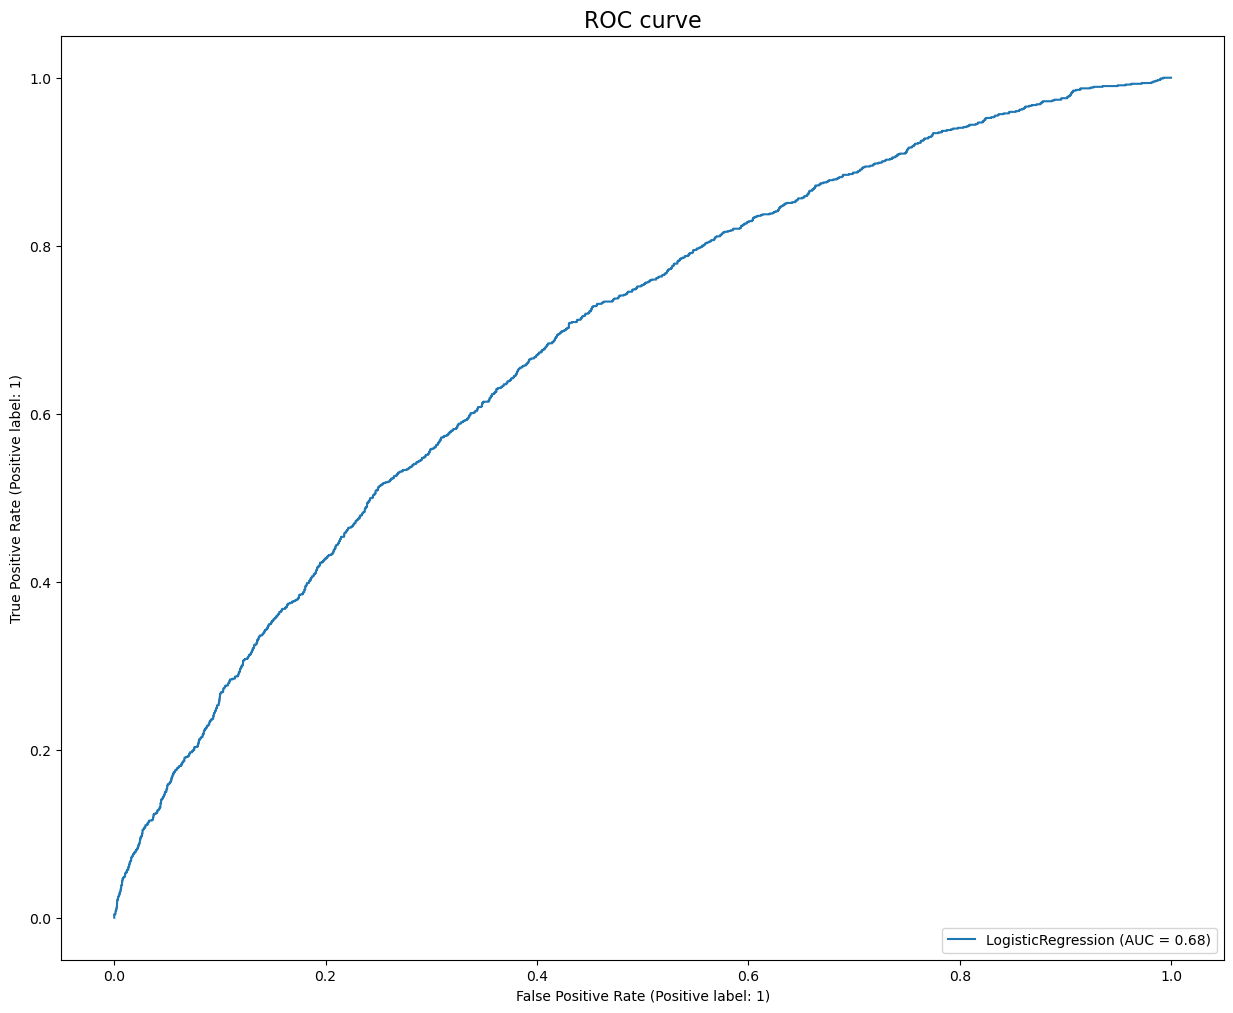



3) KS Statistic
KS Statistic: 0.8553508428067425
P-Value: 0.0


4) SHAP


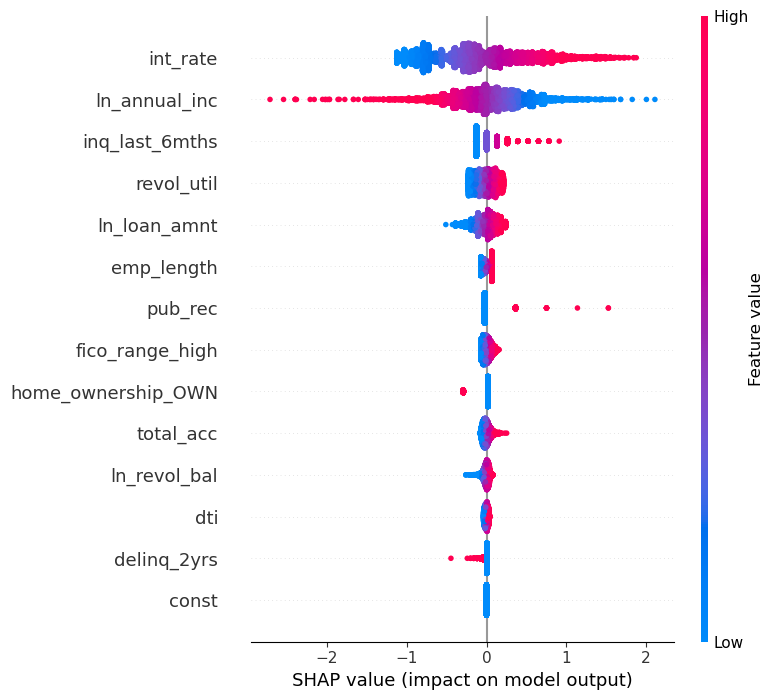

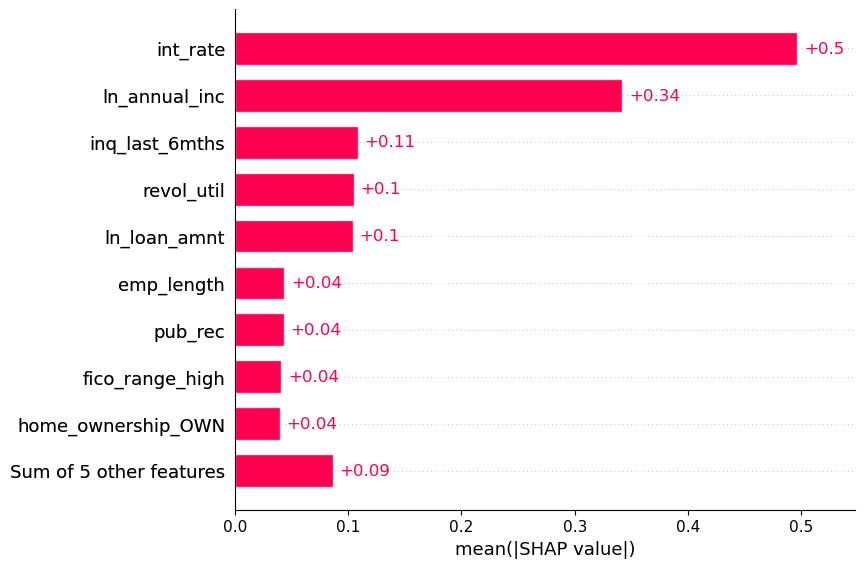

In [18]:
evaluate_model(logit_model, X_test, y_test, optimal_threshold)

# Building a Credit Scorecard Using Logistic Regression

In this section, we will walk through the process of building a credit scorecard using logistic regression. A credit scorecard is a statistical model used to predict the likelihood that a loan applicant will default on a loan. Logistic regression is a commonly used method for this purpose due to its effectiveness in binary classification tasks.

Code source: https://github.com/BruceYanghy/End-to-End-Guide-to-Building-a-Credit-Scorecard-Using-Machine-Learning/blob/main/End-to-End-Guide-to-Building-a-Credit-Scorecard-Using-Machine-Learning.ipynb



## Data Preparation:

* Import necessary libraries.
* Load and preprocess the data.
* Split data into train and test sections.


In [19]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = { 'pandas','numpy', 'matplotlib', 'seaborn','toad','pickle','sklearn'}
missing = required - installedPackages
if missing:
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install seaborn
    !pip install toad
    !pip install pickle
    !pip install sklearn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [20]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
%pip install toad

import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle

Note: you may need to restart the kernel to use updated packages.


In [21]:
X = X_copy
y = y_copy
X['target'] = y
data = X
# set an exclude list for the scorecard package Toad
exclude_list = ['target']
# Split the scaled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature filtering

* Feature filtering by missing value, IV & corrrelation：
    * If the missing value rate is greater than the threshold, delete the feature
    * If the correlation coefficient is greater than the threshold, delete the feature
    * If the IV is smaller than the threshold, delete the features

In [22]:
train_selected, drop_lst= toad.selection.select(frame = X_train,
                                                target=X_train['target'], 
                                                empty = 0.7, 
                                                iv = 0.02, corr = 1, 
                                                return_drop=True,
                                                exclude=exclude_list)

In [23]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['emp_length', 'delinq_2yrs', 'total_acc', 'home_ownership_OWN',
        'ln_revol_bal'], dtype=object),
 'corr': array([], dtype=object)}

## Output the IV Table to a DataFrame

To understand the importance of each feature in predicting the target variable, we calculate the Information Value (IV) for each feature. The Information Value is a metric used to quantify the predictive power of a feature in a logistic regression model. Here's how we can output the IV table to a DataFrame:

1. **Function Definition**:
    - The `output_iv_importance` function takes two arguments: `train_selected` (the selected training data) and `label_col` (the name of the target variable column).
    - Within the function, we use the `toad.quality` method to calculate the IV for each feature, specifying `iv_only=True` to get only the IV values.
    - We then reset the index of the resulting DataFrame to get a clean format and rename the columns to `name` and `iv`.

2. **Function Call**:
    - We call the `output_iv_importance` function with the selected training data and the target variable column ('target') to obtain a DataFrame (`df_iv`) containing the feature names and their corresponding IV values.


In [24]:
def output_iv_importance(train_selected, label_col):
    # Calculate the IV for each feature in the dataset
    feat_import_iv = toad.quality(train_selected, label_col, iv_only=True)
    # Extract the IV values from the result
    feat_import_iv = feat_import_iv['iv']
    # Reset the index of the DataFrame to get a clean format
    feat_import_iv = feat_import_iv.reset_index()
    # Rename the columns for better readability
    feat_import_iv.columns = ['name', 'iv']
    # Return the DataFrame containing feature names and their IV values
    return feat_import_iv

# Call the function to get the IV DataFrame for the training data
df_iv = output_iv_importance(train_selected, 'target')

In [25]:
#Show information value
df_iv.head(8)

,name,iv
0,int_rate,0.363231
1,fico_range_high,0.155412
2,revol_util,0.105121
3,ln_annual_inc,0.044821
4,inq_last_6mths,0.041035
5,ln_loan_amnt,0.038062
6,dti,0.034227
7,pub_rec,0.023888


## 3. Feature Binning

Feature binning transforms continuous or numerical variables into categorical features. This technique simplifies the logistic regression model and reduces the risk of overfitting. 


### Steps for feature binning:
1. **Initialization:** c = toad.transform.Combiner()
2. **Training binning:**
c.fit(dataframe, y = 'target', method = 'chi', min_samples = 0.05, n_bins = None, empty_separate = False)

y: target column
method: binning method, supports chi (chi-square binning), dt (decision tree binning), kmean, quantile, step (equal step size binning)
min_samples: Each box contains the least number of samples, which can be a number or a proportion 
n_bins: the number of bins; If it is not possible to divide so many boxes the maximum number of bins will be divided.
empty_separate: Whether to separate empty boxes separately 

3. **check binning nodes:** c.export()
4. **Manually adjust binning:** c.load(dict)
5. **Apply binning results:** c.transform(dataframe, labels=False)
labels: Whether to convert the binning results into box labels. If False, output 0, 1, 2… (discrete variables are sorted according to the proportion), and if True output (-inf, 0], (0,10], (10, inf).

In [26]:
import time
start = time.time()
combiner = toad.transform.Combiner()
# use the filtered features for training
# Use the stable chi-square binning, 
# specifying that each bin has at least 5% data to ensure stability
# empty values will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['target'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

0.11314147710800171


In [27]:
combiner

In [28]:
# save 1: pickle combiner
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [29]:
filename

'CreditScore_save1_combiner.pkl'

In [30]:
# load the model from disk
combiner = pickle.load(open(filename, 'rb'))

In [31]:
#output binning
bins = combiner.export()

In [32]:
len(bins)

8

In [33]:
bins

{'int_rate': [7.9, 11.03, 13.98, 16.4],
 'dti': [-0.8737459149836003, 0.08257584645604776, 0.8111301221269472],
 'fico_range_high': [-1.1120401866802694,
  -0.830900074733318,
  -0.12804979486593962,
  0.15309031708101173,
  0.43423042902796305,
  0.9965106529218657,
  1.5587908768157683],
 'inq_last_6mths': [0.12326919358618167, 1.9994223973204968],
 'pub_rec': [3.962249597419102],
 'revol_util': [-0.9743178394425471,
  -0.17259547738944267,
  0.5641223688215181,
  1.427237884725536],
 'ln_annual_inc': [-0.8430840044761986,
  0.048850877581704505,
  0.9831703651846226],
 'ln_loan_amnt': [-0.22011321558838862, 0.7470751332291857]}

In [34]:
#apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(X_test[train_selected_bin.columns])

### Data broken out into Bins

In [35]:
train_selected_bin.head()

,int_rate,dti,fico_range_high,inq_last_6mths,pub_rec,revol_util,ln_annual_inc,ln_loan_amnt,target
26645,4,3,1,0,1,2,1,1,0
627,1,3,3,1,0,3,1,0,0
32817,2,3,3,0,1,2,1,1,0
29074,2,3,2,0,0,4,1,1,0
4877,1,2,4,0,0,2,1,0,1


In [36]:
test_bin.head()

,int_rate,dti,fico_range_high,inq_last_6mths,pub_rec,revol_util,ln_annual_inc,ln_loan_amnt,target
31741,2,2,2,1,0,2,1,1,0
4281,2,3,1,0,0,3,3,1,0
11669,3,0,2,1,0,3,1,0,0
4639,1,1,7,0,0,0,1,1,0
20409,3,2,0,0,0,2,0,0,1


In [37]:
features_list = [feat for feat in train_selected_bin.columns if feat not in exclude_list]
len(features_list)

8

### Information Value of Bins
Just Interest Rate, remove comments to see all variables

<AxesSubplot: xlabel='int_rate', ylabel='prop'>

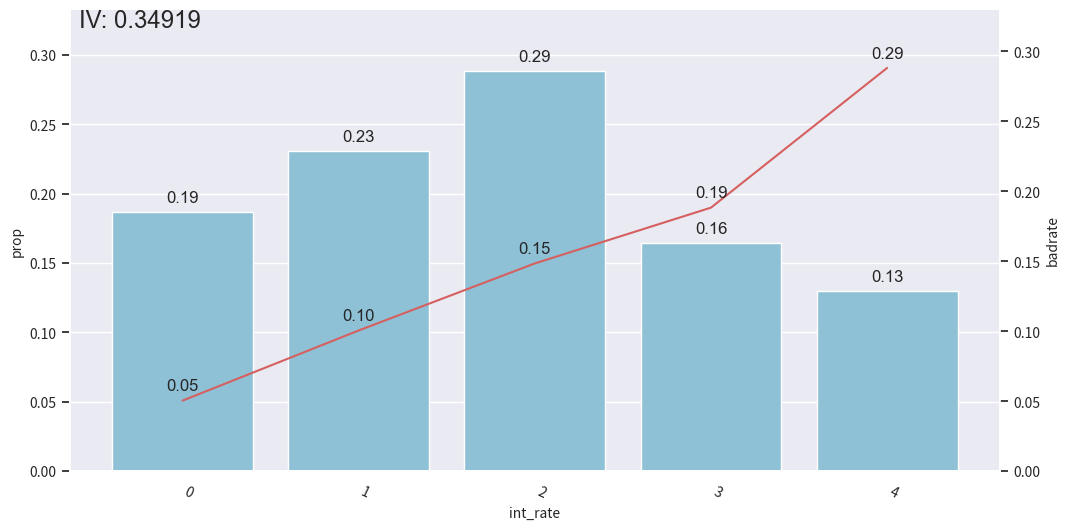

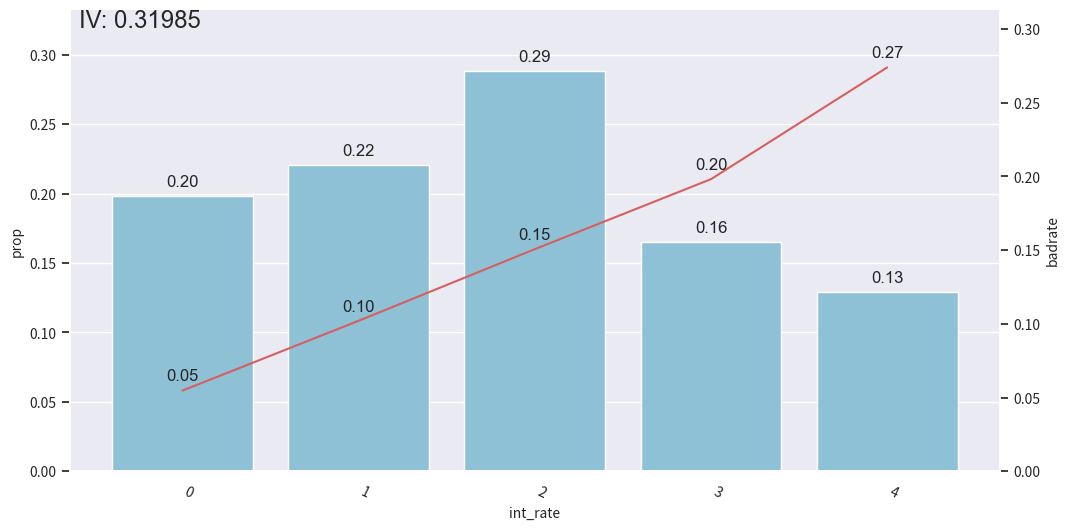

In [38]:
#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='int_rate',target='target')
bin_plot(test_bin,x='int_rate',target='target')
#to see all IV graphs remove '#' below
#for feature in features_list:
#    bin_plot(train_selected_bin,x=feature,target='target')
#    bin_plot(test_bin,x=feature,target='target')


## 4. Transform to WOE

In [39]:
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['target'],
                            exclude=exclude_list)
#transform testing set
test_woe = t.transform(test_bin)

### WOE values applied to bins

In [40]:
train_woe.head()

,int_rate,dti,fico_range_high,inq_last_6mths,pub_rec,revol_util,ln_annual_inc,ln_loan_amnt,target
26645,0.879773,0.193415,0.314774,-0.199471,0.579505,0.011017,0.07886,-0.063468,0
627,-0.406359,0.193415,-0.049614,0.112772,-0.040495,0.269993,0.07886,-0.123610,0
32817,0.037796,0.193415,-0.049614,-0.199471,0.579505,0.011017,0.07886,-0.063468,0
29074,0.037796,0.193415,0.160038,-0.199471,-0.040495,0.482195,0.07886,-0.063468,0
4877,-0.406359,0.049173,-0.158405,-0.199471,-0.040495,0.011017,0.07886,-0.123610,1


In [41]:
final_data_woe = pd.concat([train_woe,test_woe])

In [42]:
#save 2: pickle woe_transform
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))

In [43]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]

## Calculate PSI

* PSI (Population Stability Index) reflects the stability of the distribution. We often use it to screen features and evaluate model stability. The industry level is to drop features with a PSI greater than 0.2

In [44]:
#get the feature name
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list]).sort_values(0)
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})

In [45]:
psi_df

,feature,psi
0,pub_rec,0.000067
1,ln_loan_amnt,0.000079
2,revol_util,0.000216
3,inq_last_6mths,0.000257
4,dti,0.000383
5,ln_annual_inc,0.000502
6,fico_range_high,0.000935
7,int_rate,0.001125


In [46]:
# features less than 0.25
psi025 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)

In [47]:
# keep exclude list
for i in exclude_list:
    if i in psi025:
        pass
    else:
       psi025.append(i) 

In [48]:
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi025]
off_woe_psi = test_woe[psi025]

In [49]:
# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])

In [50]:
#save 3: final data table with transformed woe
final_data_woe.to_csv('CreditScore_save3_final_data_woe.csv')

## 5. Output IV
This shows the IV for all variables after applying WOE to bins

In [51]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
df_iv=output_iv_importance(final_data_woe[features_use+['target']],'target')
df_iv

,name,iv
0,int_rate,0.342865
1,fico_range_high,0.155497
2,revol_util,0.092938
3,inq_last_6mths,0.040587
4,ln_annual_inc,0.037165
5,ln_loan_amnt,0.029605
6,pub_rec,0.020213
7,dti,0.018160


## 6. Model Tuning

This is the logistic regression ran on the WOE values

In [52]:
def check_train_test_auc(x_train,y_train,x_test,y_test):
    
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')


    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)

    
    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    
    print('train AUC',AUC(pred_train, y_train))
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test AUC',AUC(pred_OOT, y_test))
    #Change threshold to adjust confusion matrix
    threshold = .6

    
    evaluate_model(lr, x_test, y_test, threshold)

## WOE Logistic Regression

train AUC 0.6845728352384264
Test AUC 0.6772474746847478


1) CONFUSION MATRIX


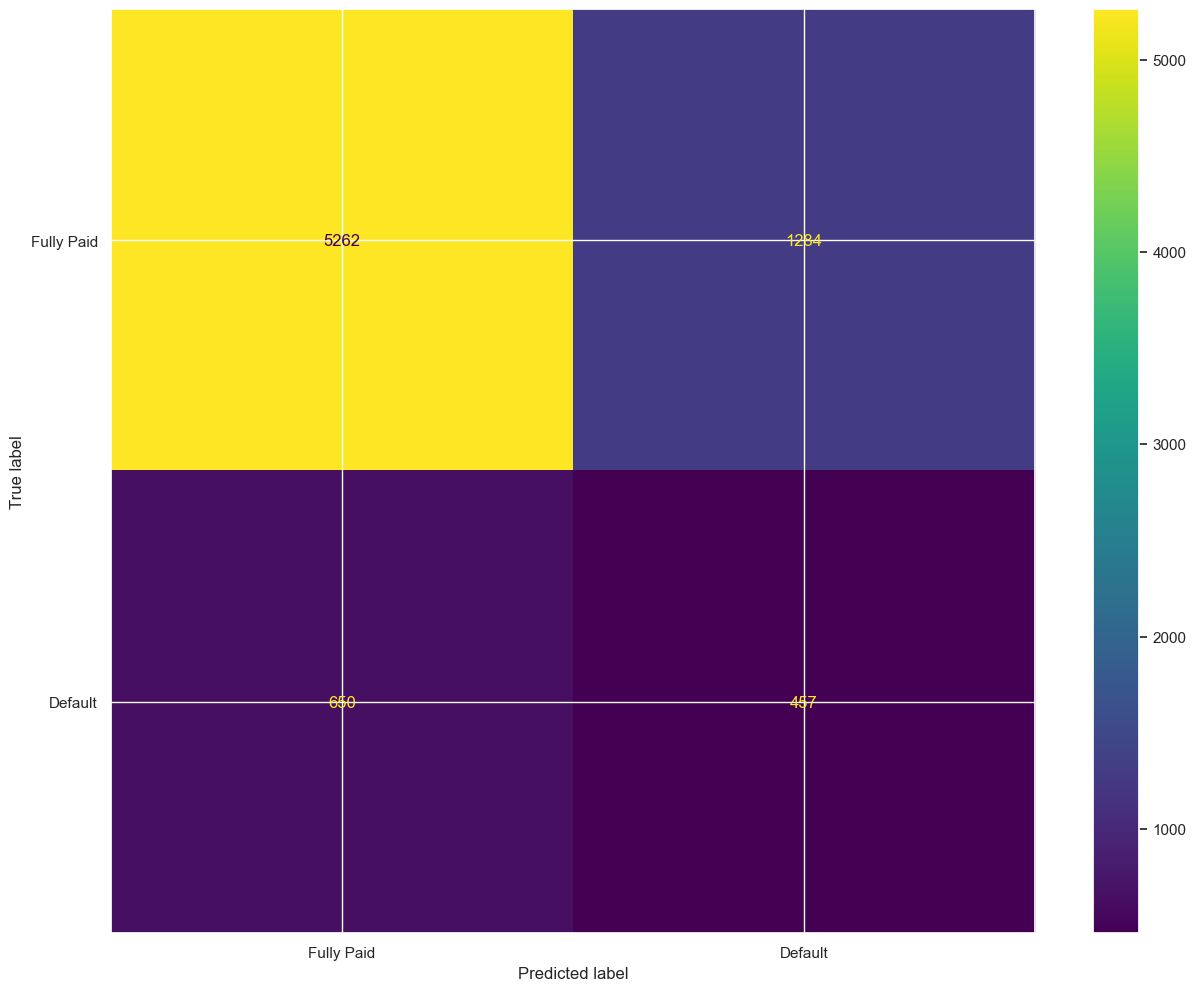



2) AUC and ROC Curve
AUC score:  0.6772474746847478


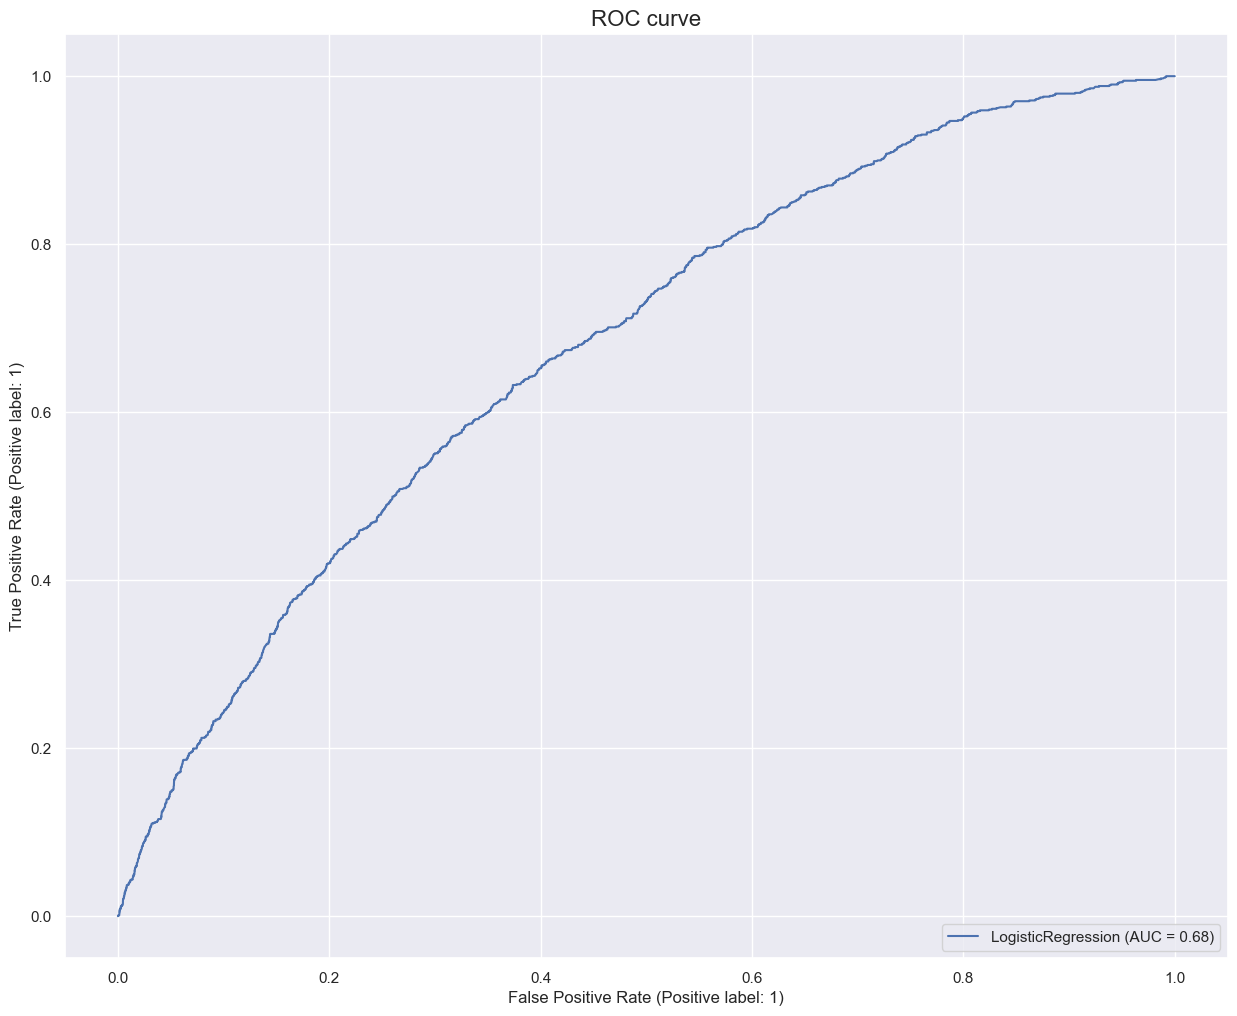



3) KS Statistic
KS Statistic: 0.8553508428067425
P-Value: 0.0


4) SHAP


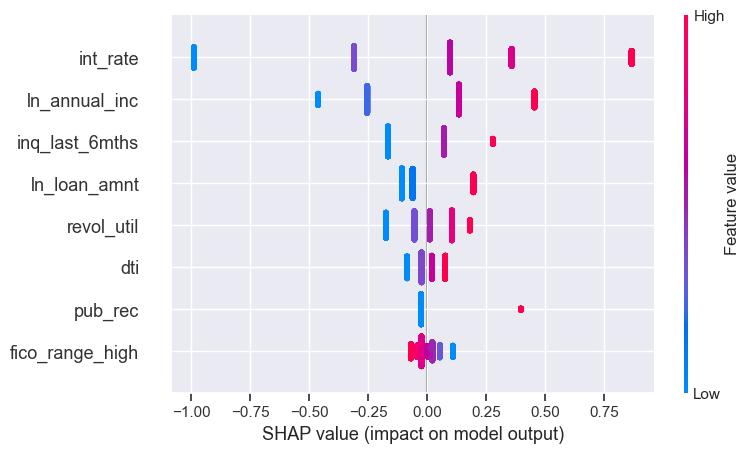

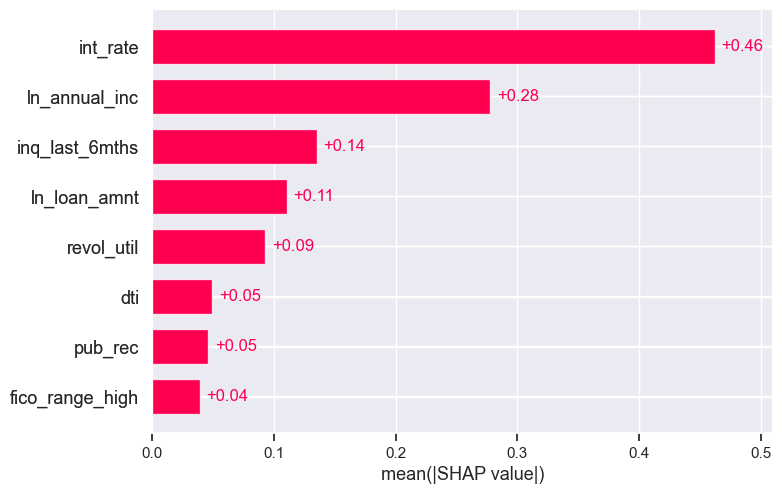

In [53]:

check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['target'],
                     x_test =test_woe[features_use] ,y_test = test_woe['target'])

In [54]:
def get_evaluation_scores(label, predictions):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.metrics import balanced_accuracy_score
    tp, fn, fp, tn = confusion_matrix(label,predictions,labels=[1,0]).reshape(-1)
    print('True Positive：',tp)
    print('True Negative：',tn)
    print('False Positive：',fp)
    print('False Negative：',fn)
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    print('accuracy: ',accuracy)
    recall = tp/(tp+fn)
    print('（recall）: ',recall)
    precision = tp/(tp+fp)
    print('（precision）: ',precision)
    #f1 score = 2*(P*R)/(P+R)
    f1 = 2*precision*recall/(precision+recall)
    print('F1 score: ',f1)
    
    print(classification_report(label, predictions))
    
    print('balanced_accuracy_score: ',balanced_accuracy_score(label,predictions))
    return precision, recall

def evaluate_result(df_train,df_test,features_name):
    from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
    import seaborn as sns
    import matplotlib.pyplot as plt
    start = time.time()
    x_train = df_train[features_name]
    y_train = df_train['target']

    x_test  = df_test[features_name]
    y_test  = df_test['target']

    model = GradientBoostingClassifier(n_estimators=250,random_state=0)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    get_evaluation_scores(label = y_test, predictions=predictions)
    feat_importances = pd.Series(model.feature_importances_, index=features_name)
    feat_importances=pd.DataFrame(feat_importances).reset_index()
    feat_importances.columns=['feature_name','feature_importance']
    feat_importances=feat_importances.sort_values(['feature_importance'],ascending=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,15))

    sns_plot1=sns.barplot(x='feature_importance',y='feature_name', data=feat_importances, estimator=sum)
    plt.title("Features Importance",size=18)
    plt.ylabel('', size = 15)
    plt.tick_params(labelsize=18)
    return feat_importances,model,x_train,y_train,x_test,y_test

True Positive： 5
True Negative： 6541
False Positive： 5
False Negative： 1102
accuracy:  0.8553508428067425
（recall）:  0.004516711833785004
（precision）:  0.5
F1 score:  0.008952551477170993
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      6546
           1       0.50      0.00      0.01      1107

    accuracy                           0.86      7653
   macro avg       0.68      0.50      0.47      7653
weighted avg       0.80      0.86      0.79      7653

balanced_accuracy_score:  0.5018764432984996


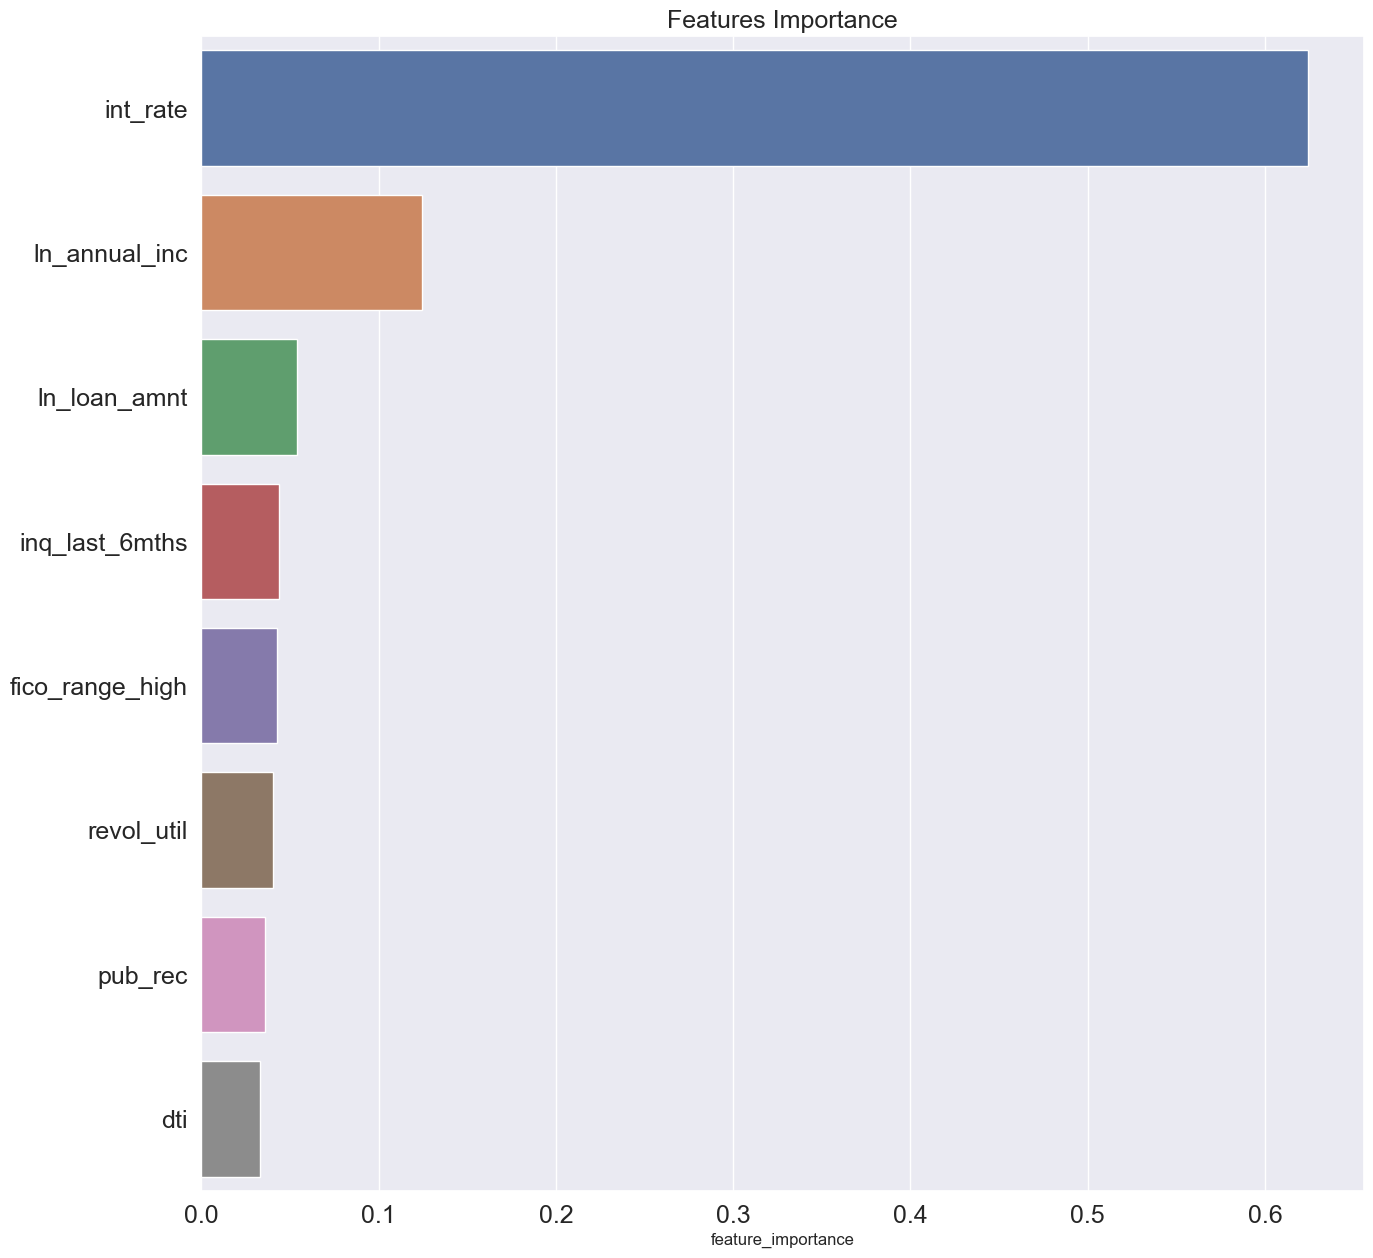

In [55]:
fet_importance_GBDT_reason,model,x_train,y_train,x_test,y_test = evaluate_result(df_train=train_woe,
                df_test=test_woe,
                features_name=features_use)

In [56]:
fet_importance_GBDT_reason

,feature_name,feature_importance
7,int_rate,0.624615
5,ln_annual_inc,0.124734
1,ln_loan_amnt,0.054009
3,inq_last_6mths,0.043913
6,fico_range_high,0.042743
2,revol_util,0.040653
0,pub_rec,0.036088
4,dti,0.033246


In [57]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))

    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.step(recall, precision, color='orange', where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure 
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

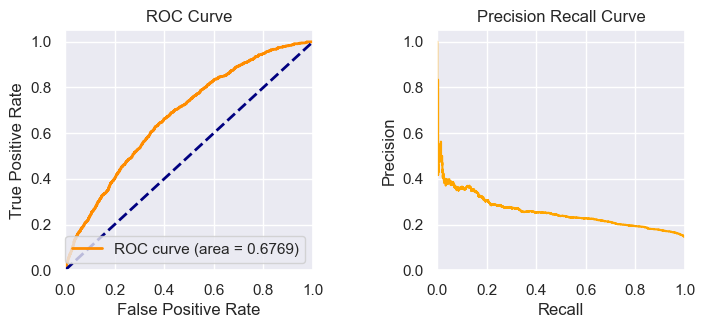

In [58]:
probs = model.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

## 7. Model Production

In [59]:
#prepare train & test data
x_train = train_woe[features_use]
y_train=train_woe['target']
x_test =test_woe[features_use] 
y_test = test_woe['target']

In [60]:
#Train LR
#lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

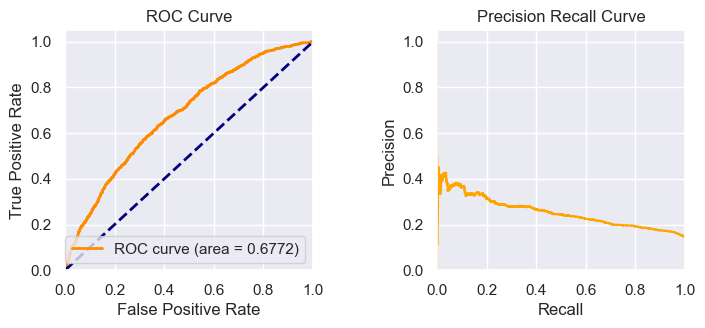

In [61]:
#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

## 8. Scorecard Generation

In [62]:
# scorecard tuning
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['target'])

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x0000011B13535CD0>,
          pdo=80,
          transer=<toad.transform.WOETransformer object at 0x0000011B13459790>)

In [63]:
# save 5: save the model to disk
filename = 'CreditScore_save5_ScoreCard.pkl'
pickle.dump(card, open(filename, 'wb'))

In [64]:
#inference on test data
test = x_test
test['CreditScore'] = card.predict(test)
test['CreditScore'].describe()

count    7653.000000
mean      745.651562
std        22.896511
min       690.288849
25%       723.800364
50%       759.102598
75%       764.970350
max       778.327876
Name: CreditScore, dtype: float64

In [65]:
#inference on whole data
data['CreditScore'] = card.predict(data)
data['CreditScore'].describe()

count    38263.000000
mean       609.622853
std         82.973758
min        363.380923
25%        549.427115
50%        603.664946
75%        666.545017
max        820.228541
Name: CreditScore, dtype: float64

In [66]:
#output the scorecard
final_card_score=card.export()


## Scorecard of variables

In [67]:
#transform the scorecard into dataframe and save to csv
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df=score_card_df.append(temp)
score_card_df.head(50)

,variable,binning,score
0,pub_rec,[-inf ~ 3.962249597419102),76.75
1,pub_rec,[3.962249597419102 ~ inf),30.94
0,ln_loan_amnt,[-inf ~ -0.22011321558838862),83.52
1,ln_loan_amnt,[-0.22011321558838862 ~ 0.7470751332291857),78.77
2,ln_loan_amnt,[0.7470751332291857 ~ inf),51.84
0,revol_util,[-inf ~ -0.9743178394425471),94.09
1,revol_util,[-0.9743178394425471 ~ -0.17259547738944267),80.63
2,revol_util,[-0.17259547738944267 ~ 0.5641223688215181),73.31
3,revol_util,[0.5641223688215181 ~ 1.427237884725536),62.87
4,revol_util,[1.427237884725536 ~ inf),54.32


## Logistic Regression Without Log Variables

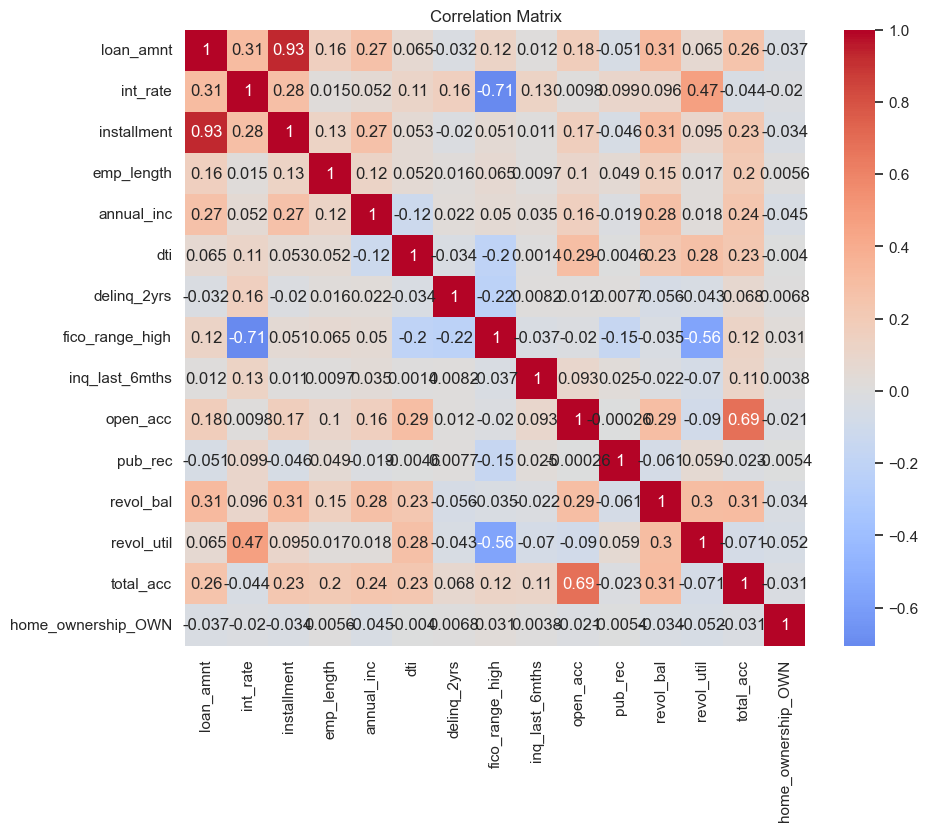

In [68]:
# Load data
loans = pd.read_csv('Documents/LendingClub/filtered_loans.csv')

#Make Target Variable
loans['default'] = loans['loan_status'].apply(lambda x:0 if x ==1 else 1)
loans = loans.drop(columns = ['loan_status', 'zip_code', 'verification_status_Not Verified', 'verification_status_Source Verified', 'term_ 36 months', 'term_ 60 months'])
loans = loans.dropna()

#Get rid of nan and inf values
loans.replace(-np.inf, np.nan, inplace=True)
loans = loans.dropna()

# Apply Scaler
loans = loans.drop(columns = ['verification_status_Verified','last_fico_range_high', 'home_ownership_OTHER', 'home_ownership_MORTGAGE', 'home_ownership_NONE',  'home_ownership_RENT', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other','purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding'])
# Initializing the StandardScaler
scaler = StandardScaler()

# List of numerical features to scale
numerical_features = ['total_acc','revol_bal','loan_amnt', 'emp_length', 'dti', 'fico_range_high','delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_util', 'annual_inc']  

# Applying the scaler to the numerical features
loans[numerical_features] = scaler.fit_transform(loans[numerical_features])

# Define the feature columns and target variable
X = loans.drop(columns=['default'], axis = 1)  # Replace 'target_column' with the actual name of your target variable
y = loans['default']  # Replace 'target_column' with the actual name of your target variable

# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

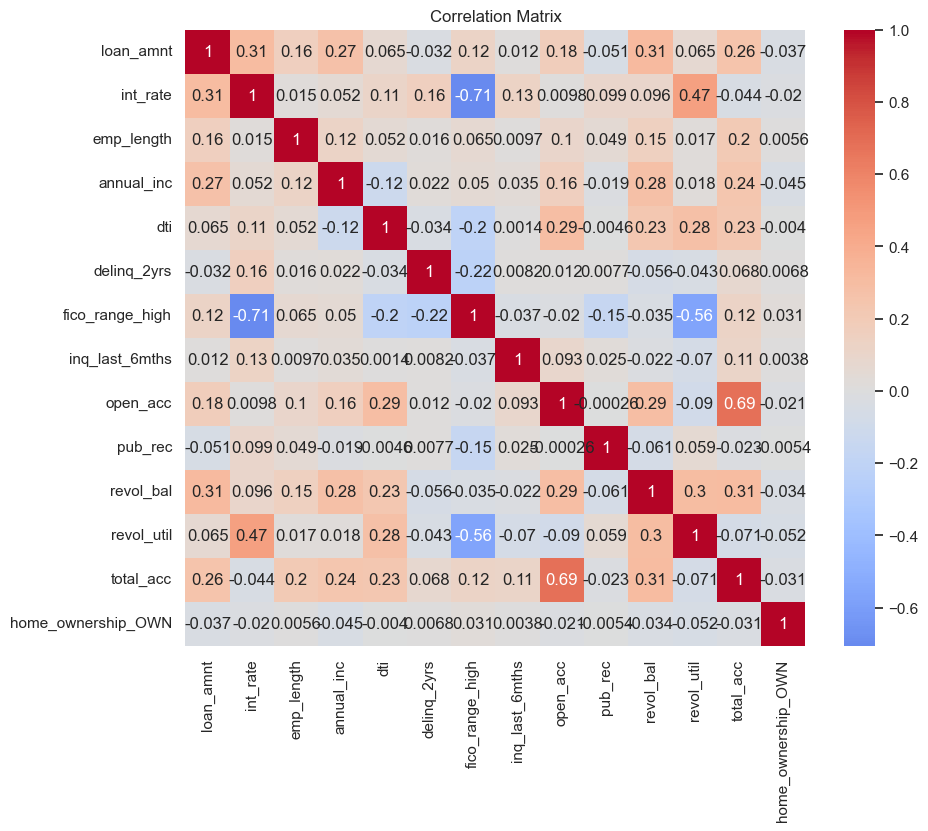

In [69]:
X = X.drop(columns = ['installment'])
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [70]:
# Split the scaled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing SMOTE
smote = SMOTE(random_state=42)

# Applying SMOTE to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the summary which includes coefficients and p-values
print("\nStatsmodels Logistic Regression Model Summary:")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.637093
         Iterations 6

Statsmodels Logistic Regression Model Summary:
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                53762
Model:                          Logit   Df Residuals:                    53747
Method:                           MLE   Df Model:                           14
Date:                Fri, 28 Jun 2024   Pseudo R-squ.:                 0.08087
Time:                        09:02:02   Log-Likelihood:                -34251.
converged:                       True   LL-Null:                       -37265.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.1824      0.064    

[LibLinear]

1) CONFUSION MATRIX


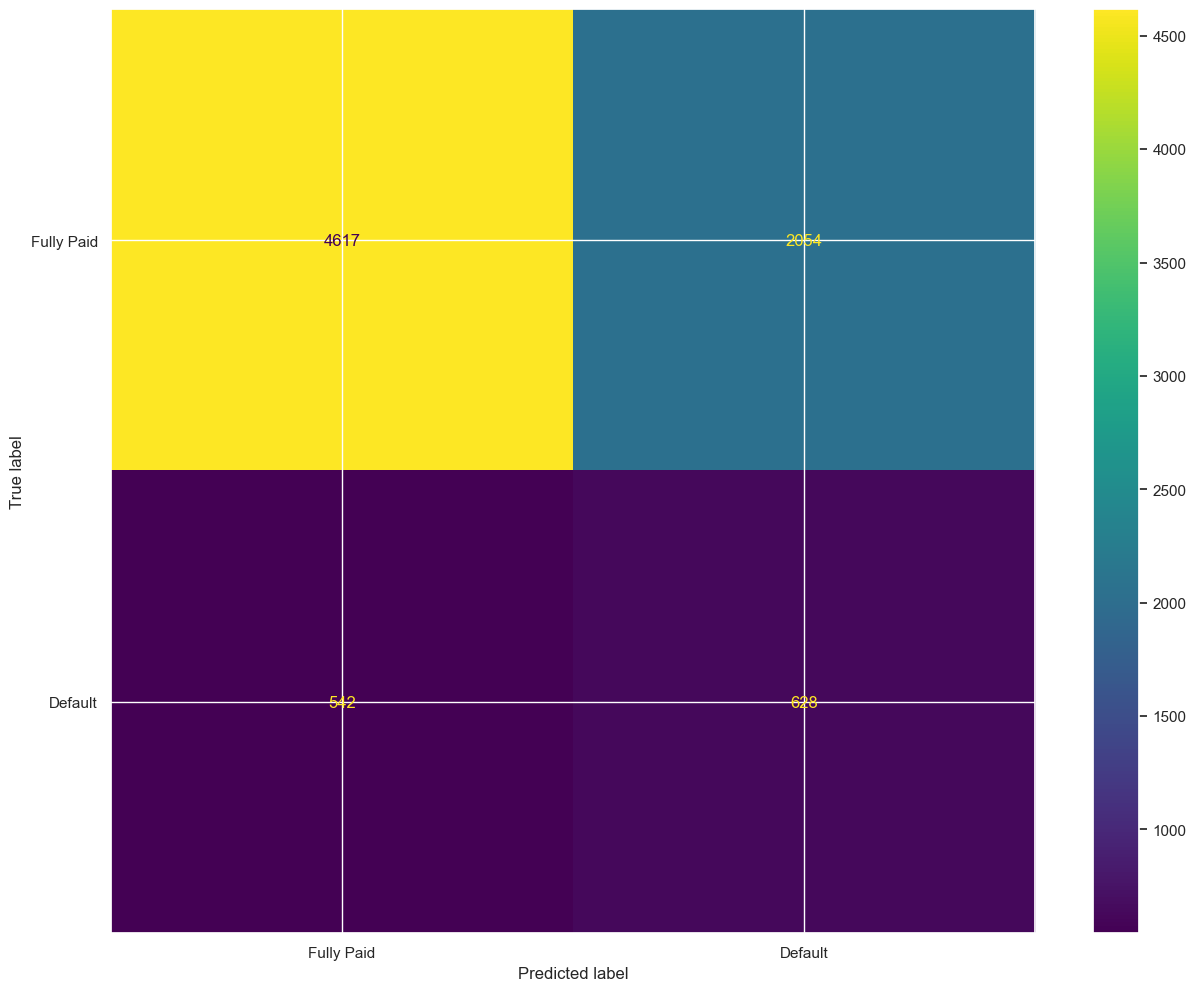



2) AUC and ROC Curve
AUC score:  0.6748220067212721


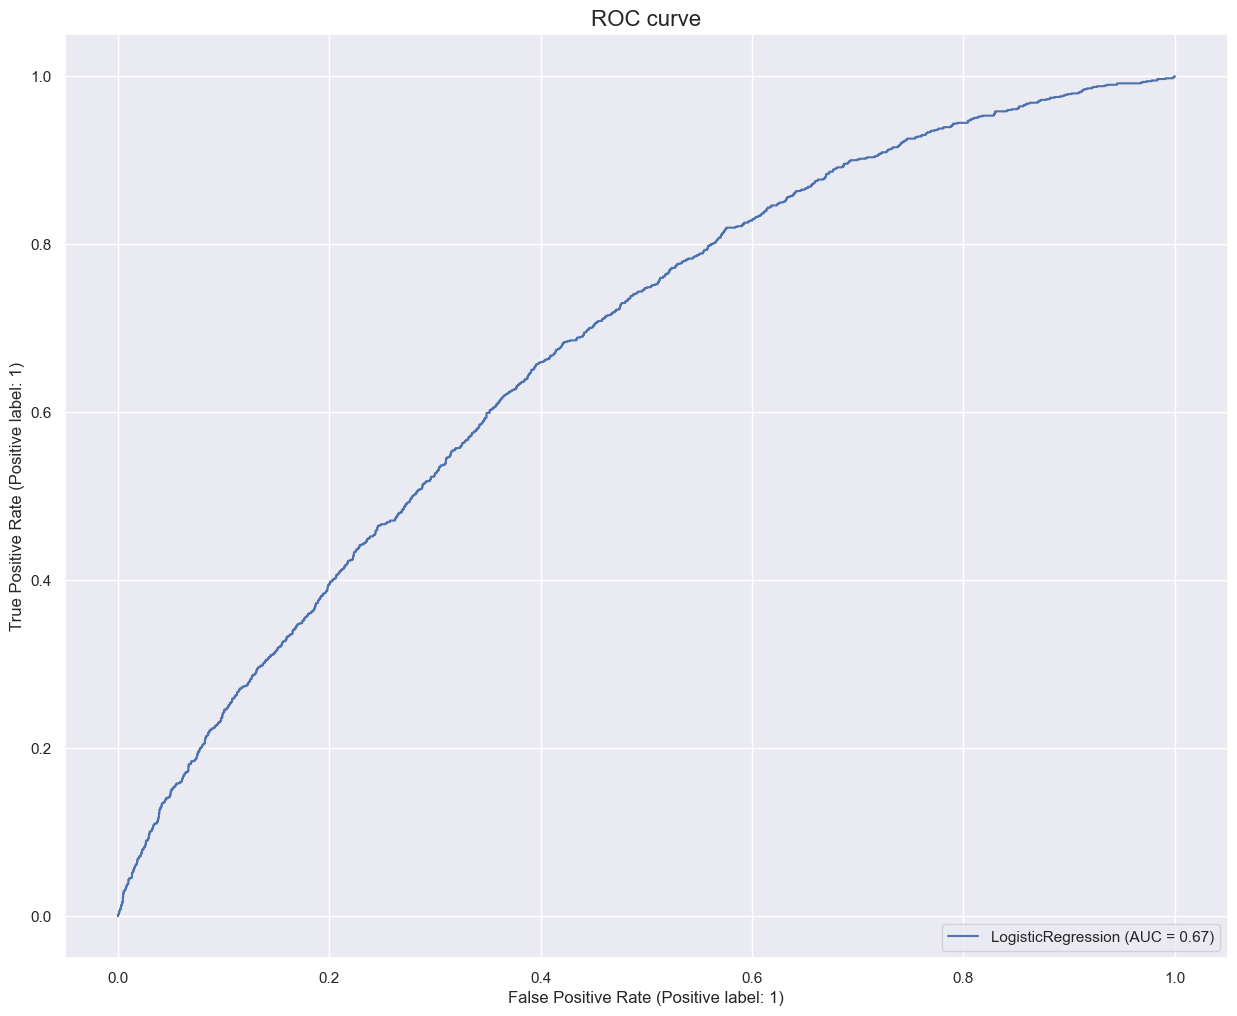



3) KS Statistic
KS Statistic: 0.8507843387323045
P-Value: 0.0


4) SHAP


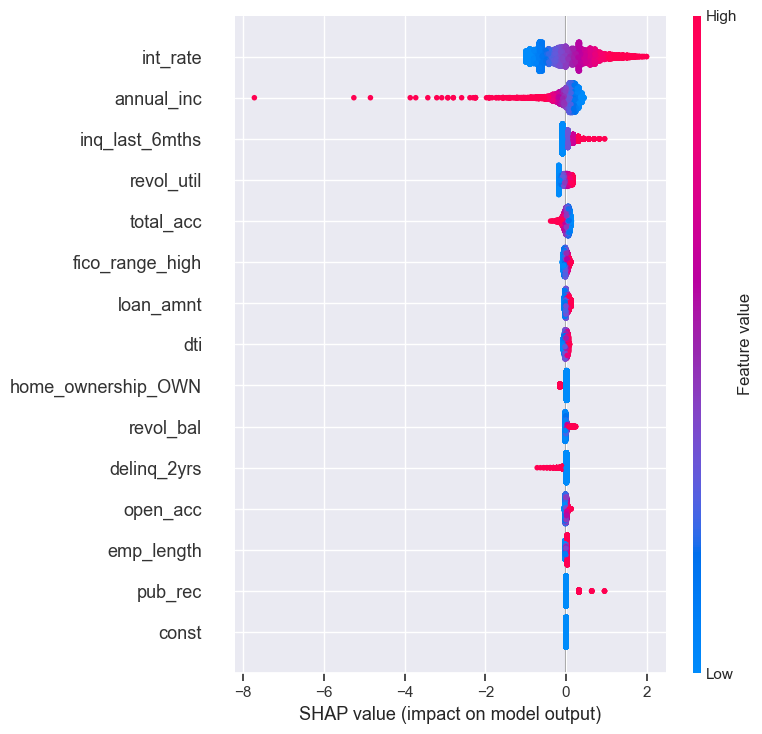

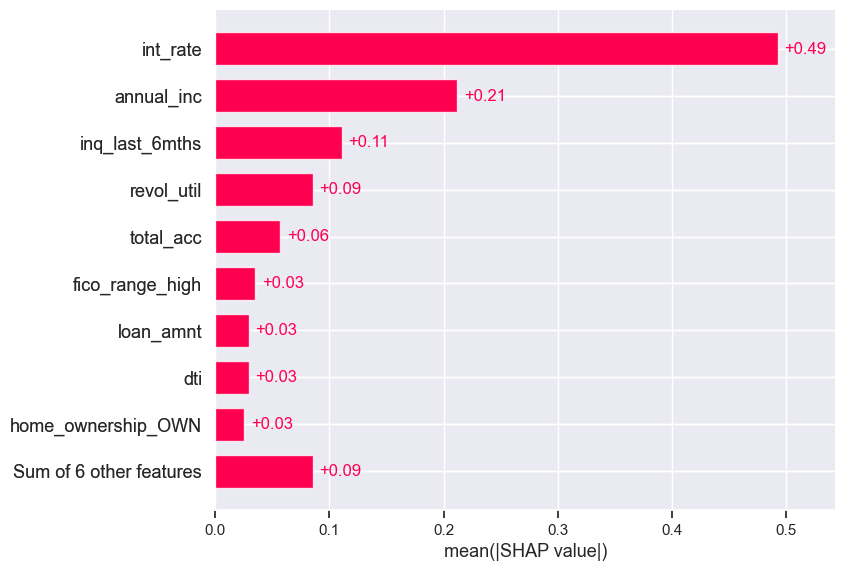

In [71]:
logit_model = LogisticRegression(solver='liblinear', multi_class ='ovr', class_weight = {0:0.2, 1:0.8}, verbose = 1, random_state=42)
logit_model.fit(X_train, y_train)
threshold = .82
evaluate_model(logit_model, X_test, y_test, threshold)

# XGBoost

First, let’s load all the required packages. We will need xgboost, as the core package, as well as associated packages to evalute results:

In [72]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter


## Variable Selection

Going to use all data in XGBoost as XGBoost is generally more robust to correlated variables than logistic regression. Thus, you can include more correlated variables in XGBoost without the same level of concern.

Split the data using sklearn library using a 80% train 20% test split

In [73]:
data = loans_copy
X = data.drop('default', axis = 1)
y = data[['default']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y.head()

,default
0,0
1,1
2,0
3,0
4,0


 Create a XGBoost classifier, and then train the model with the training set with the help of the fit function.

In [74]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('Accuracy of XGBClassifier classifier on train set: {:.2f}'.format(xgb.score(X_train, y_train))) 
print('Accuracy of XGBClassifier classifier on test set: {:.2f}'.format(xgb.score(X_test, y_test))) 
print('Recall of XGBClassifier classifier on test set: {:.2f}'.format(recall_score(y_test, y_pred_xgb))) 
print('Precision of XGBClassifier classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred_xgb))) 
print('ROC/AUC of XGBClassifier classifier on test set: {:.2f}'.format(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])))

Accuracy of XGBClassifier classifier on train set: 0.95
Accuracy of XGBClassifier classifier on test set: 0.88
Recall of XGBClassifier classifier on test set: 0.45
Precision of XGBClassifier classifier on test set: 0.62
ROC/AUC of XGBClassifier classifier on test set: 0.90


XGBoost scale_pos_weight is calculated as the number of negative examples over positive examples.

In [75]:
# count each class using counter
counter = Counter(y['default'])
# calculate scale_pos_weight value
class_0 = counter[0]
class_1 = counter[1]
weight = counter[0] / counter[1]
print('scale_pos_weight value: %.3f' % weight)

scale_pos_weight value: 5.938


### Objective = “binary:logistic”

By default, the objective function is reg:squarederror (regression with squared loss). However, we will use **‘binary:logistic’** to perform the binary classification task.

Now we fit our XGBoost model given the above parameters we have chosen for our case:

In [76]:
xgb = XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print('Accuracy of XGBClassifier classifier on train set: {:.2f}'.format(xgb.score(X_train, y_train))) 
print('Accuracy of XGBClassifier classifier on test set: {:.2f}'.format(xgb.score(X_test, y_test))) 
print('Recall of XGBClassifier classifier on test set: {:.2f}'.format(recall_score(y_test, y_pred_xgb))) 
print('Precision of XGBClassifier classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred_xgb))) 
print('ROC/AUC of XGBClassifier classifier on test set: {:.2f}'.format(roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])))

Accuracy of XGBClassifier classifier on train set: 0.91
Accuracy of XGBClassifier classifier on test set: 0.84
Recall of XGBClassifier classifier on test set: 0.77
Precision of XGBClassifier classifier on test set: 0.47
ROC/AUC of XGBClassifier classifier on test set: 0.90


## Hyperparameters Tunning

The below is the list of hyperparameters and thier ranges we will experiment with manually:

1. max_depth: [1, 3, 5, 10, 50, 100], where default = 6
2. min_child_weight: [0.1, 1, 10, 100], where default = 1
3. gamma: [0, 0.2, 0.4, 0.8, 10, 100], where default = 0
4. booster: [gbtree or dart], where default = gbtree
5. learning_rate: [ 0.1, 0.3, 0.6, 0.9, 10, 100], where default = 0.3
6. n_estimators: [1, 10, 100, 500], where default = 100
7. subsample: [0.2, 0.5, 0.7, 1], where default = 1
8. colsample_bytree: [0.2, 0.5, 0.7, 1], where default = 1
9. reg_lambda: [ 0, 0.2, 0.4, 0.8, 10, 100], where default = 1

### max_depth

This parameter is used to specify the maximum depth of each tree. Max_depth influences the complexity of each tree, the higher the value, the more likely we may have overfitting. Typically we want to consider this hyperparameter between 3–10.

In [77]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, max_depth = 1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, max_depth = 3),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, max_depth = 5),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, max_depth = 10),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, max_depth = 50),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, max_depth = 100)
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.79092,0.79199,0.40272,0.91770,0.90538
1,0.81892,0.80946,0.42353,0.89204,0.90752
2,0.87574,0.82566,0.44267,0.80973,0.90083
3,0.99987,0.86711,0.53661,0.57080,0.89448
4,1.00000,0.86902,0.54976,0.50354,0.89614
5,1.00000,0.86902,0.54976,0.50354,0.89614


### Vizualization

Train accuracy indicates overfitting with it significantly exceeds test accuracy

<Figure size 1200x800 with 0 Axes>

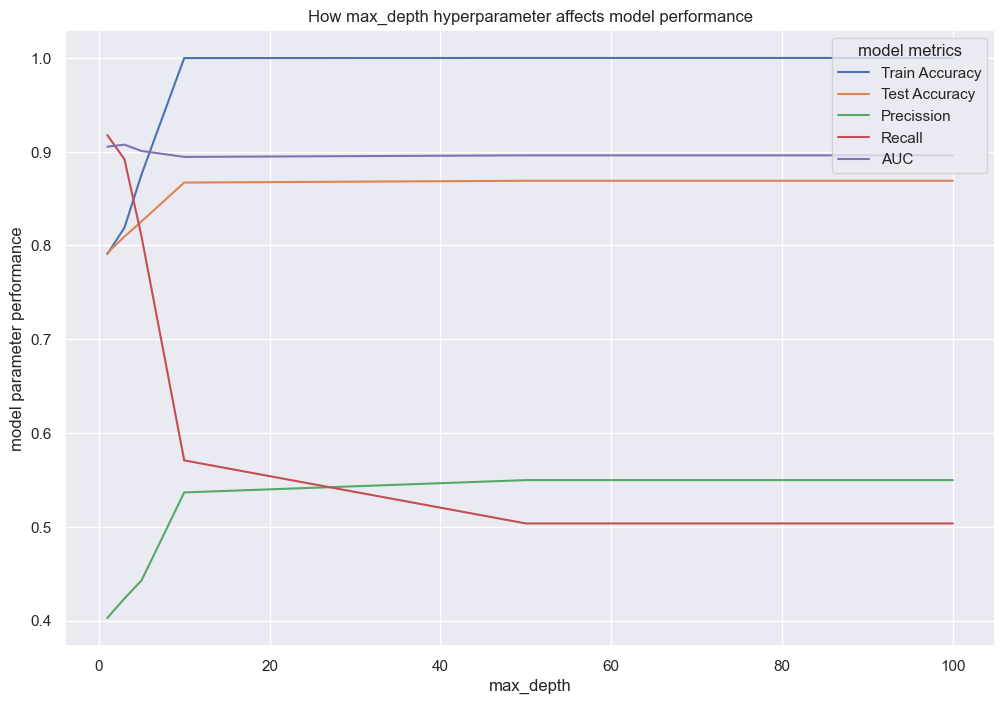

In [78]:
#viz
plt.figure(figsize = (12,8))
x = [1, 3, 5, 10, 50, 100]
# corresponding y axis values
y = clf_compare
plt.figure(figsize = (12,8))
plt.plot(x,y)
plt.xlabel('max_depth')
plt.ylabel('model parameter performance')
plt.title('How max_depth hyperparameter affects model performance')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Precission', 'Recall', 'AUC'],loc='upper right', title='model metrics')
plt.show()

With this set of hyperparameters, we observe that max_depth beyond “3” results in overfitting.

In [79]:
max_depth = 3

### min_child_weight

This hyperparameter affects the node partitioning logic, the smaller values will result in more nodes and a more complex model. On the contrary, the higher values will result in a more conservative model.

In [80]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, min_child_weight = 0.1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, min_child_weight = 1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, min_child_weight = 10),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, min_child_weight = 100)
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:

    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1

clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.91607,0.83727,0.46028,0.74867,0.89688
1,0.90989,0.84160,0.46966,0.76726,0.89691
2,0.89343,0.83089,0.45000,0.78053,0.89721
3,0.84296,0.81877,0.43502,0.86195,0.90519


### Vizualization

<Figure size 1200x800 with 0 Axes>

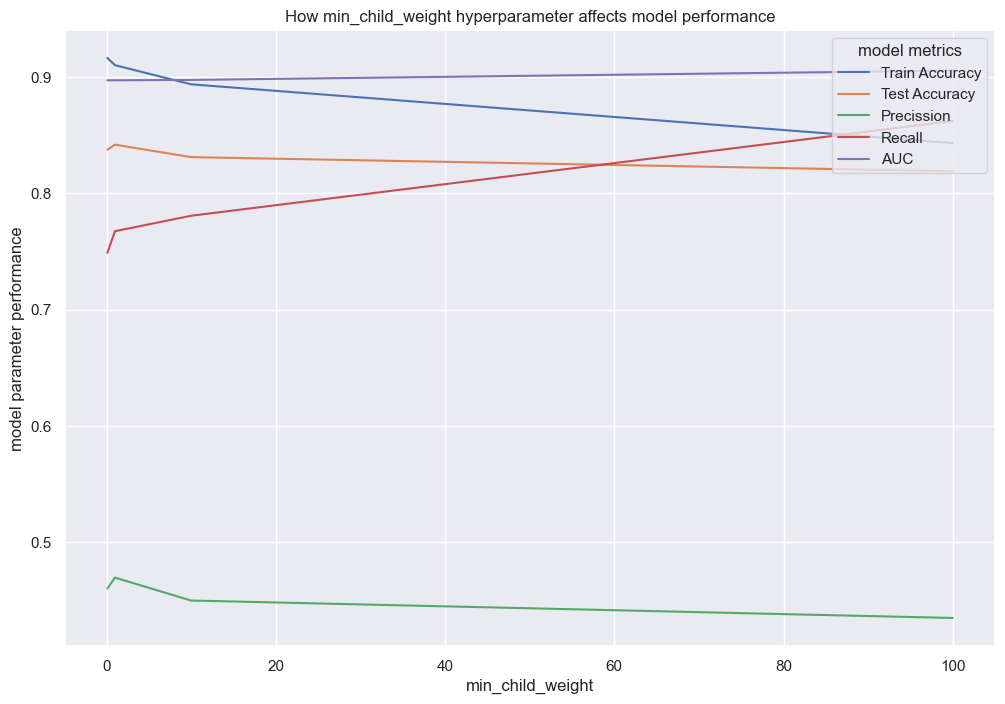

In [81]:
plt.figure(figsize = (12,8))
x = [0.1, 1, 10, 100]
# corresponding y axis values
y = clf_compare
plt.figure(figsize = (12,8))
plt.plot(x,y)
plt.xlabel('min_child_weight')
plt.ylabel('model parameter performance')
plt.title('How min_child_weight hyperparameter affects model performance')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Precission', 'Recall', 'AUC'],loc='upper right', title='model metrics')
plt.show()

Going to go with a higher min child weight around 90, the order of model metrics matches the graph better at that weight based off the article I used to implement XGBoost: https://medium.com/@data.science.enthusiast/xgboost-how-it-works-and-hyperparameter-tuning-python-code-for-fintech-case-13c6199f9436

In [82]:
min_child_weight = 90

### gamma

This hyperparameter also affects the partitioning logic of the tree, the higher values will result in a more conservative model.

In [83]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, gamma = 0.1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, gamma = 0.2),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, gamma = 0.4),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, gamma = 0.8),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, gamma = 1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, gamma = 10),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, gamma = 100)
    
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.91100,0.83969,0.46602,0.77080,0.89658
1,0.91135,0.83918,0.46458,0.76018,0.89634
2,0.91190,0.84033,0.46659,0.75398,0.89636
3,0.91126,0.83688,0.46018,0.76195,0.89617
4,0.89190,0.82885,0.44673,0.78673,0.89782
5,0.82399,0.80883,0.42232,0.88761,0.90554
6,0.79500,0.79378,0.40440,0.91150,0.90335


### Vizualization

<Figure size 1200x800 with 0 Axes>

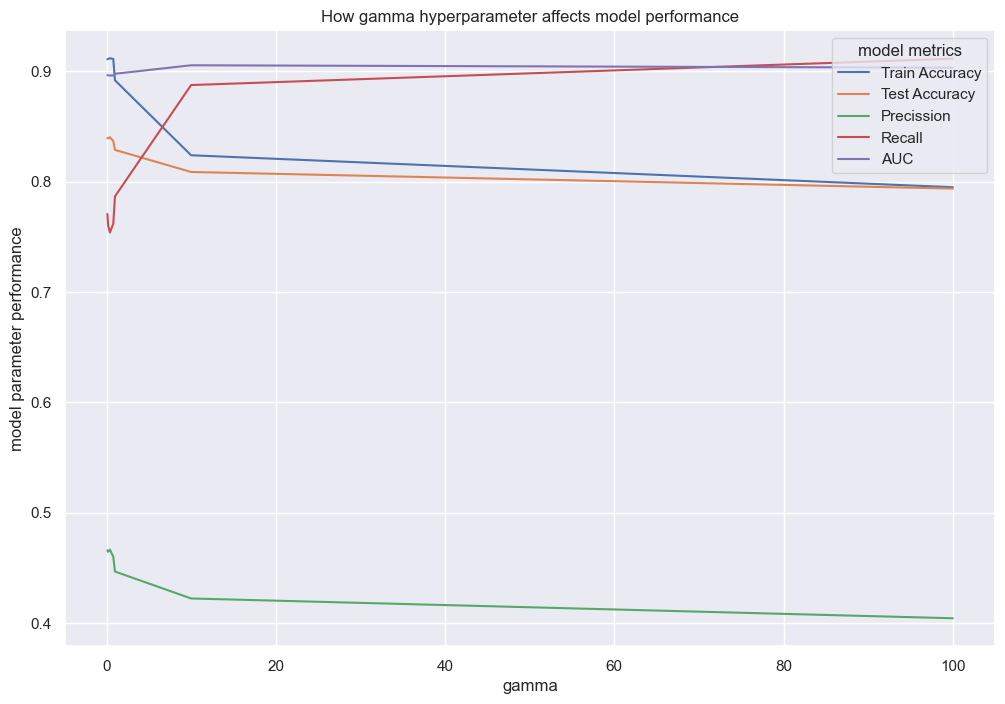

In [84]:
plt.figure(figsize = (12,8))
x = [0.1, 0.2, 0.4, 0.8, 1, 10, 100]
# corresponding y axis values
y = clf_compare
plt.figure(figsize = (12,8))
plt.plot(x,y)
plt.xlabel('gamma')
plt.ylabel('model parameter performance')
plt.title('How gamma hyperparameter affects model performance')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Precission', 'Recall', 'AUC'],loc='upper right', title='model metrics')
plt.show()

Setting gamma to 20 based off test and train accuracy

In [85]:
gamma = 20

### Booster

In [86]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, booster = "gbtree"),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, booster = "dart")
    
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.90989,0.8416,0.46966,0.76726,0.89691
1,0.90989,0.8416,0.46966,0.76726,0.89691


No significant changes

### Learning_rate

The learning rate is the pace at which the XGBoost algorithm learns, smaller values may provide a more complex and better performance model, however at longer training times.

In [87]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, learning_rate = 0.01),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, learning_rate = 0.1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, learning_rate = 0.3),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, learning_rate = 0.6),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, learning_rate = 0.9),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, learning_rate = 1)
    
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.80498,0.79977,0.41158,0.90619,0.90244
1,0.84289,0.81954,0.43647,0.86637,0.90698
2,0.90989,0.84160,0.46966,0.76726,0.89691
3,0.96569,0.84938,0.48257,0.62478,0.88691
4,0.98457,0.84517,0.46837,0.55044,0.86705
5,0.98865,0.85180,0.48756,0.55487,0.86793


0.1 has the highest AUC

In [88]:
learning_rate = .1

### N_estimators

This is the number of trees XGBoost will produce during the training step. Higher number can result in a more complex model that may lead to overfitting.

In [89]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, n_estimators = 1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, n_estimators = 10),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, n_estimators = 50),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, n_estimators = 100),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, n_estimators = 500)
    
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.80670,0.80066,0.41080,0.88230,0.89641
1,0.81298,0.80372,0.41636,0.90088,0.90465
2,0.86528,0.82592,0.44423,0.82832,0.90207
3,0.90989,0.84160,0.46966,0.76726,0.89691
4,0.99978,0.86583,0.53272,0.56195,0.88975


### Vizualization

<Figure size 1200x800 with 0 Axes>

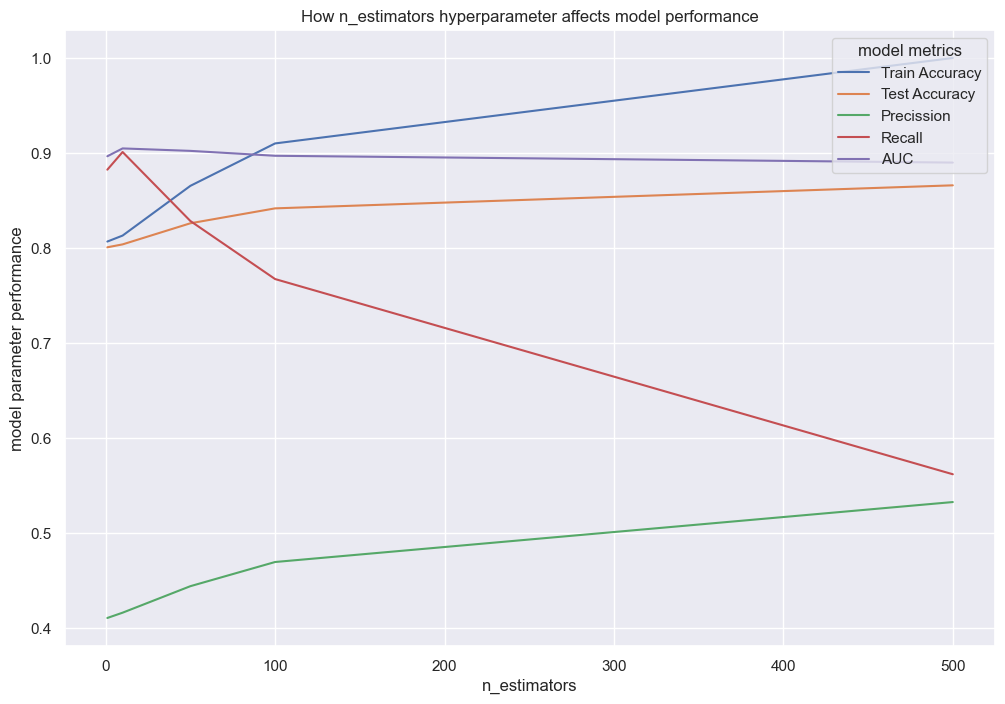

In [90]:
plt.figure(figsize = (12,8))
x = [1, 10, 50, 100, 500]
# corresponding y axis values
y = clf_compare
plt.figure(figsize = (12,8))
plt.plot(x,y)
plt.xlabel('n_estimators')
plt.ylabel('model parameter performance')
plt.title('How n_estimators hyperparameter affects model performance')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Precission', 'Recall', 'AUC'],loc='upper right', title='model metrics')
plt.show()

Over 10 results in overfitting

In [91]:
n_estimators = 10

### Subsample

This is the ratio of random samples taken prior to growing trees. By default XGBoost considers all samples, but smaller values may help fixing overfitting issue.

In [92]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, subsample = 0.2),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, subsample = 0.5),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, subsample = 0.7),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, subsample = 1)
    
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.87453,0.82145,0.43091,0.74513,0.87727
1,0.90393,0.83548,0.45745,0.76106,0.88753
2,0.91333,0.83803,0.46145,0.74159,0.89229
3,0.90989,0.84160,0.46966,0.76726,0.89691


### Vizualization

<Figure size 1200x800 with 0 Axes>

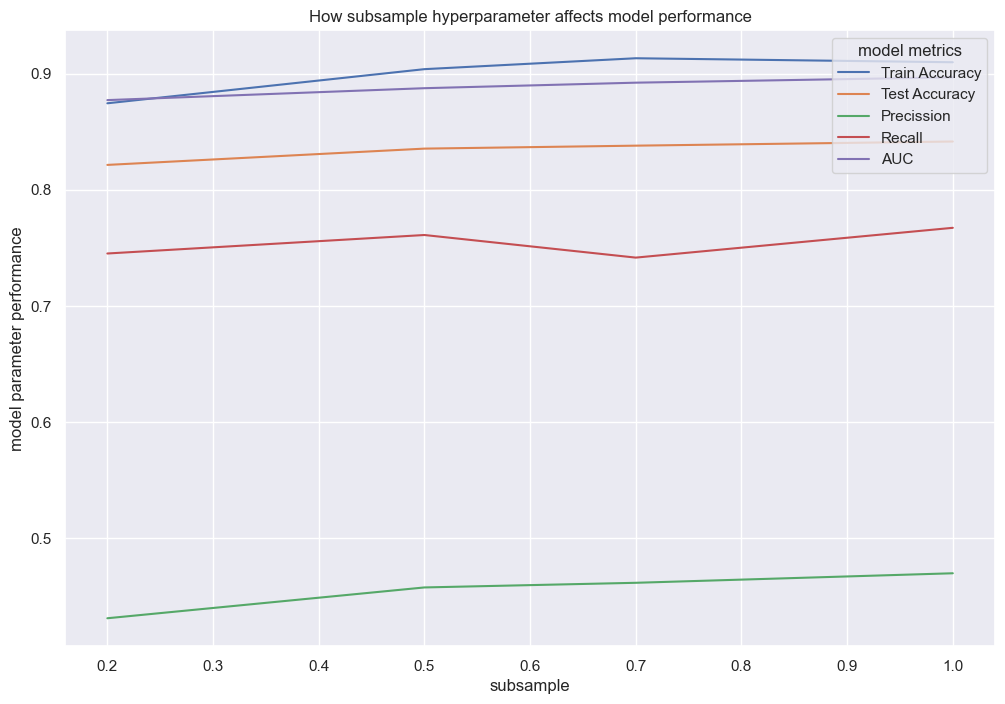

In [93]:
plt.figure(figsize = (12,8))
x = [0.2, 0.5, 0.7, 1]
# corresponding y axis values
y = clf_compare
plt.figure(figsize = (12,8))
plt.plot(x,y)
plt.xlabel('subsample')
plt.ylabel('model parameter performance')
plt.title('How subsample hyperparameter affects model performance')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Precission', 'Recall', 'AUC'],loc='upper right', title='model metrics')
plt.show()

1 results in highest auc

In [94]:
subsample = 1

### colsample_bytree

Similar to the previous parameter, but focuses on subsampling of columns when constructing each tree. This subsampling occurs once for every tree constructed.

In [95]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, colsample_bytree = 0.2),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, colsample_bytree = 0.5),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, colsample_bytree = 0.7),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, colsample_bytree = 1)
    
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.87405,0.82630,0.44319,0.80088,0.89575
1,0.89768,0.83727,0.46206,0.78673,0.89976
2,0.90711,0.84160,0.46976,0.76991,0.90020
3,0.90989,0.84160,0.46966,0.76726,0.89691


### Vizualization

<Figure size 1200x800 with 0 Axes>

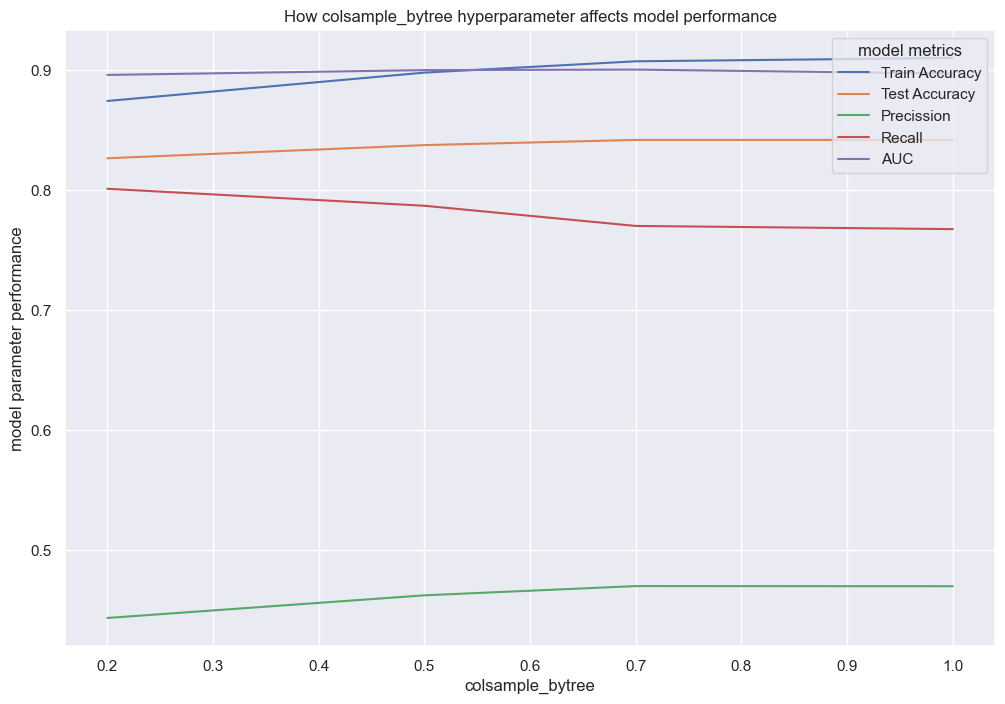

In [96]:
plt.figure(figsize = (12,8))
x = [0.2, 0.5, 0.7, 1]
# corresponding y axis values
y = clf_compare
plt.figure(figsize = (12,8))
plt.plot(x,y)
plt.xlabel('colsample_bytree')
plt.ylabel('model parameter performance')
plt.title('How colsample_bytree hyperparameter affects model performance')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Precission', 'Recall', 'AUC'],loc='upper right', title='model metrics')
plt.show()

Around .5 looks to be the best

In [97]:
colsample_bytree = .5

### reg_lambda

This is L2 regularization, and by ncreasing this value will make XGBoost model more conservative. It helps preveting overfitting.

In [98]:
xgb_clf = [
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, reg_lambda = 0),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, reg_lambda = 0.2),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, reg_lambda = 0.4),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, reg_lambda = 0.8),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, reg_lambda = 1),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, reg_lambda = 10),
    XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, reg_lambda = 100)
    
]
clf_columns = []
clf_compare = pd.DataFrame(columns = clf_columns)
row_index = 0

for alg in xgb_clf:
        
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    clf_name = alg.__class__.__name__
    clf_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 5)
    clf_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 5)
    clf_compare.loc[row_index, 'Precission'] = round(precision_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),5)
    clf_compare.loc[row_index, 'AUC'] = round(roc_auc_score(y_test, alg.predict_proba(X_test)[:,1]),5)

    row_index+=1
    
clf_compare

,Train Accuracy,Test Accuracy,Precission,Recall,AUC
0,0.91792,0.83778,0.46077,0.73805,0.89151
1,0.91426,0.84441,0.47497,0.75575,0.89555
2,0.91528,0.83714,0.46016,0.75133,0.89505
3,0.91438,0.83969,0.46513,0.74956,0.89712
4,0.90989,0.84160,0.46966,0.76726,0.89691
5,0.89388,0.83739,0.46249,0.79115,0.90204
6,0.85683,0.82566,0.44470,0.84336,0.90732


<Figure size 1200x800 with 0 Axes>

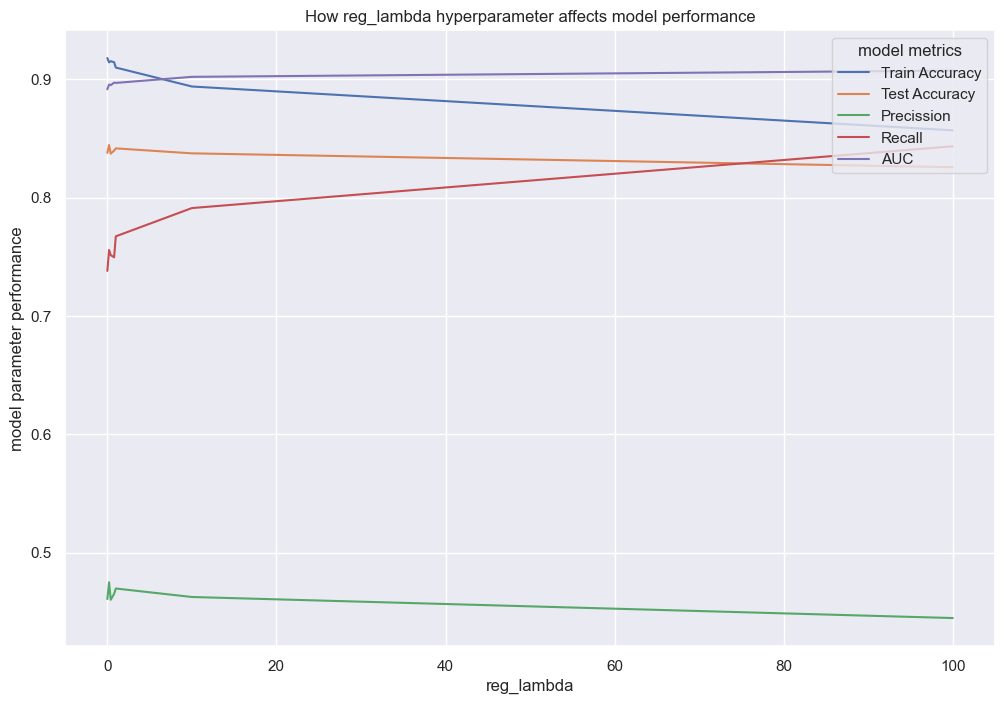

In [99]:
plt.figure(figsize = (12,8))
x = [0, 0.2, 0.4, 0.8, 1, 10, 100]
# corresponding y axis values
y = clf_compare
plt.figure(figsize = (12,8))
plt.plot(x,y)
plt.xlabel('reg_lambda')
plt.ylabel('model parameter performance')
plt.title('How reg_lambda hyperparameter affects model performance')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Precission', 'Recall', 'AUC'],loc='upper right', title='model metrics')
plt.show()


Going with 50

In [100]:
reg_lambda = 50

In [101]:
xgb_tunned = XGBClassifier(objective = "binary:logistic",scale_pos_weight = weight, subsample = subsample, 
reg_lambda = reg_lambda, n_estimators = n_estimators, min_child_weight = min_child_weight, max_depth = max_depth, learning_rate = learning_rate, 
gamma = gamma, colsample_bytree = colsample_bytree, use_label_encoder = False, random_state=42)
xgb_tunned.fit(X_train, y_train)
y_pred_xgb_tunned = xgb_tunned.predict(X_test)
print('Accuracy of XGBClassifier classifier on train set: {:.2f}'.format(xgb_tunned.score(X_train, y_train))) 
print('Accuracy of XGBClassifier classifier on test set: {:.2f}'.format(xgb_tunned.score(X_test, y_test))) 
print('Recall of XGBClassifier classifier on test set: {:.2f}'.format(recall_score(y_test, y_pred_xgb_tunned)))
print('Precision of XGBClassifier classifier on test set: {:.2f}'.format(precision_score(y_test, y_pred_xgb_tunned))) 
print('ROC/AUC of XGBClassifier classifier on test set: {:.2f}'.format(roc_auc_score(y_test, xgb_tunned.predict_proba(X_test)[:,1])))

Accuracy of XGBClassifier classifier on train set: 0.78
Accuracy of XGBClassifier classifier on test set: 0.79
Recall of XGBClassifier classifier on test set: 0.91
Precision of XGBClassifier classifier on test set: 0.39
ROC/AUC of XGBClassifier classifier on test set: 0.90


## Evaluate XGBoost

In [102]:
def xgboost_evaluate(model, x_data, y_data, threshold):
    
    y_pred_xgb_tunned = model.predict_proba(x_data)[:,1]
    
    y_pred_adjusted = (y_pred_xgb_tunned >= threshold).astype(int)
    
    print('\n') # insert a break line
    
    # print out confusion matrix coresponding to the data set
    print('1) CONFUSION MATRIX')
    cm= confusion_matrix(y_data, y_pred_adjusted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Default'])
    disp.plot()
    plt.show() 
    
    
     # print out auc and ks statistic
    print('\n')
    print('2) AUC and ROC Curve')
    auc =  metrics.roc_auc_score(y_data, y_pred_xgb_tunned)

    print("AUC score: ", auc)
    
    RocCurveDisplay.from_estimator(model, x_data, y_data)
    plt.title('ROC curve', fontsize=16)
    plt.show()
    
    # Compute KS
    
    # Compute the ROC curve and get fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_data, y_pred_xgb_tunned)
    
    # Calculate KS statistic
    ks = max(tpr - fpr)
    print('\n')
    print("KS Statistic:", ks)
    
    #print SHAP values
    #print out SHAP Values
    print('\n')
    print('4) SHAP')
    #  explain the model's predictions using SHAP
    explainer = shap.TreeExplainer(model)
    # Calculate SHAP values
    shap_values = explainer(x_data)
    # Plot the summary plot to visualize feature importance
    shap.summary_plot(shap_values, x_data)
    shap.plots.bar(shap_values)




1) CONFUSION MATRIX


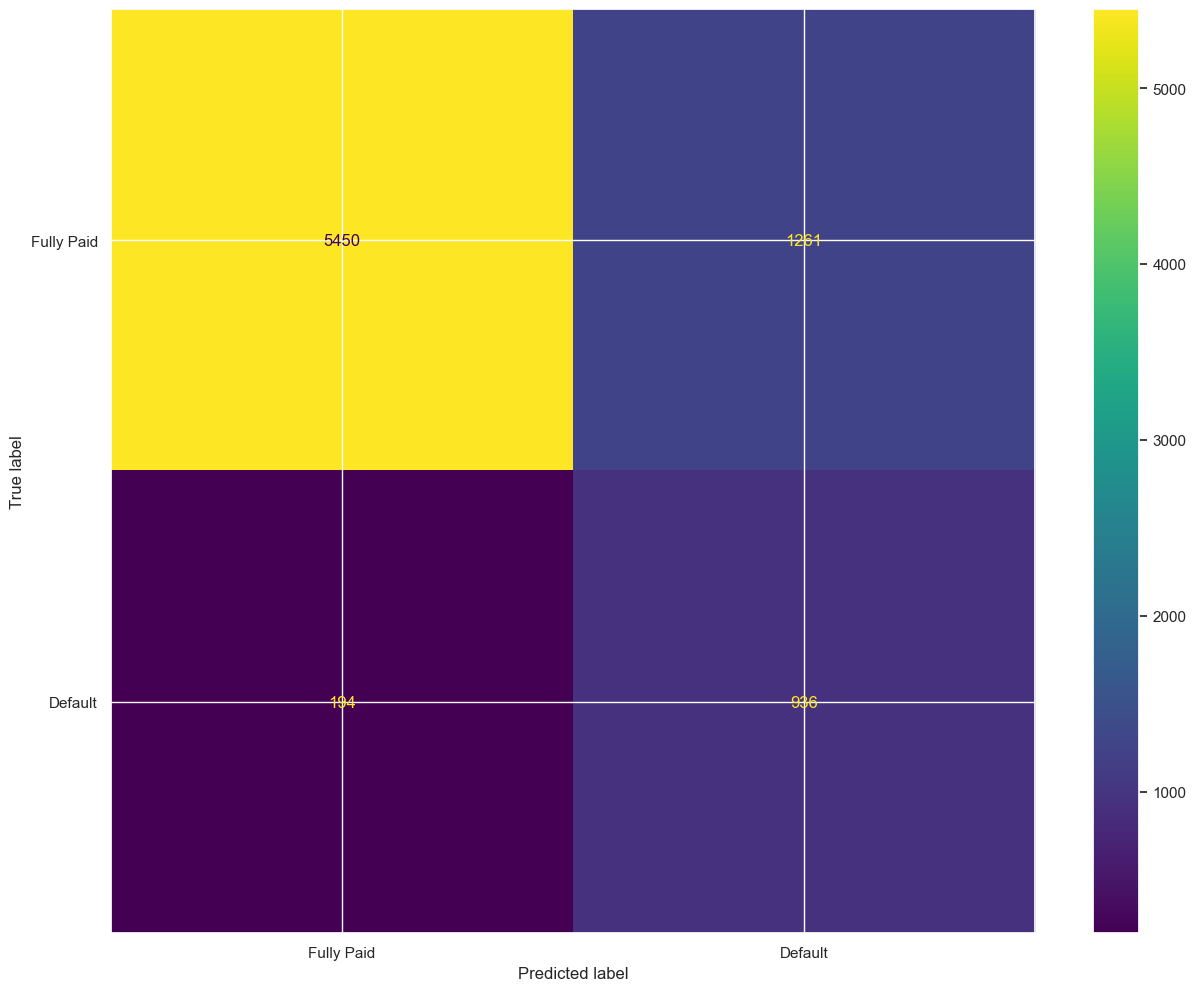



2) AUC and ROC Curve
AUC score:  0.8955117934760393


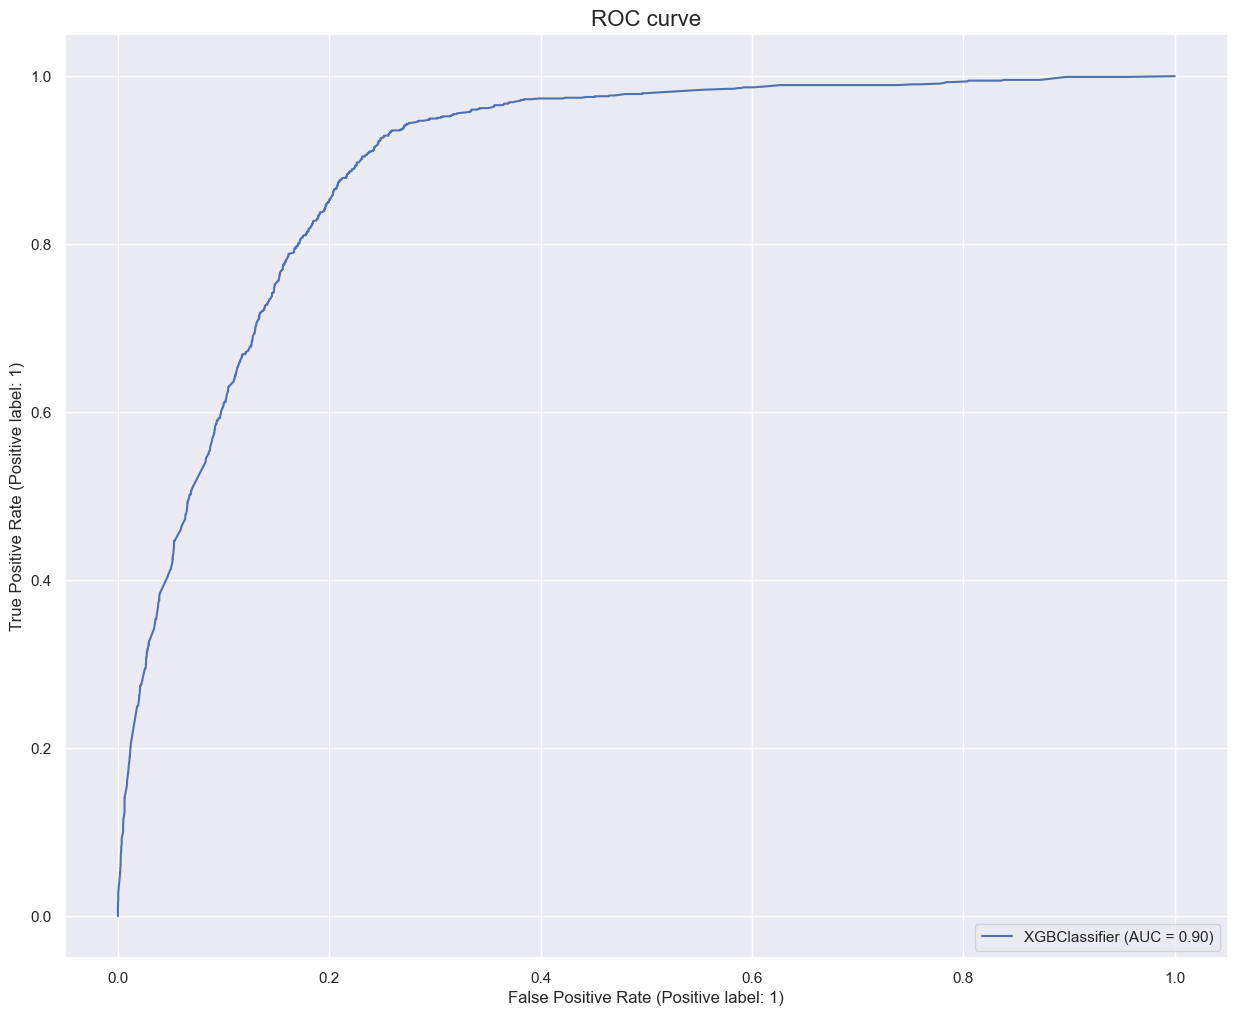



KS Statistic: 0.6778525020999732


4) SHAP


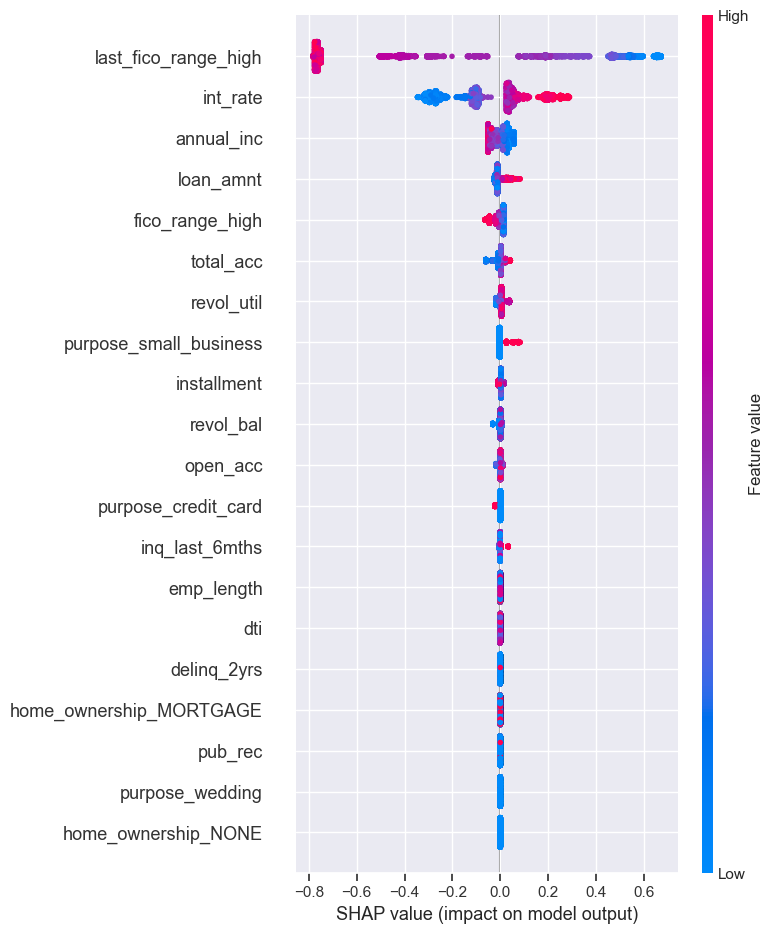

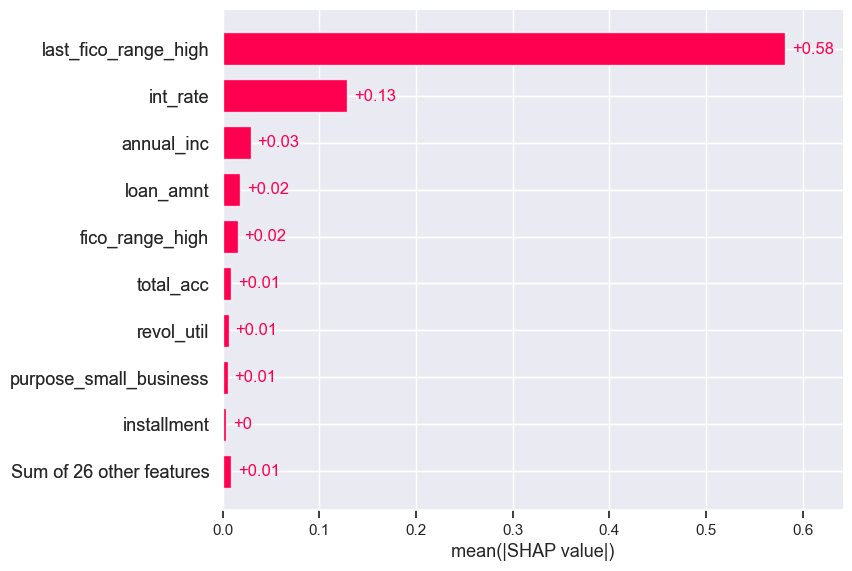

In [103]:
from xgboost import XGBClassifier
threshold = .55
xgboost_evaluate(xgb_tunned, X_test, y_test, threshold)

# Comparison of All Models

### Logistic Regression w/ Logs

* AUC Score: 0.684
* KS: 0.855
* Top 3 SHAP:
    * int_rate: + 0.5
    * annual_inc: + 0.34
    * inq_last_6mths: + 0.11

### Credit Scorecard using Binned Logistic Regression

* AUC Score: 0.677
* KS: 0.855
* Top 3 SHAP:
    * int_rate: + 0.46
    * annual_inc: + 0.28
    * inq_last_6mths: + 0.14
    
### Logistic Regression w/o Logs

* AUC Score: 0.674
* KS: 0.851
* Top 3 SHAP:
    * int_rate: + 0.49
    * annual_inc: + 0.21
    * inq_last_6mths: + 0.11
    
### XGBoost

* AUC Score: 0.896
* KS: 0.678
* Top 3 SHAP:
    * last_fico_range_high: + 0.58
    * int_rate: + 0.13
    * annual_inc: + 0.03